In [1]:
import numpy as np
from scipy import stats
from scipy import signal
import pandas as pd
import math
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os.path import sep
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from scipy.special import i0
from sklearn.metrics import r2_score

In [2]:
from fly2p_function_TQ.imaging_2p_preprocessing import low_pass_filter_TQ
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import find_stop_period_on_heading,PVA_during_stopPeriod,forwrad_speed_during_stopPeriod,bump_amplitude_during_stopPeriod,calculate_angle_difference_between_two_time_point
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import fictrack_signal_decoding
from fly2p_function_TQ.imaging_2p_PVA_functions import calcualteBumpAmplitude,  PVAangleToRoi, PVA_radian_to_angle,calculateBumpWidth_v1, von_Mises_fitting_dff_TQ
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import offset_calculation, moving_wrapped_plot_by_offset

In [4]:
#Read the imaging/behavior data after preprocessing
# pd_imaging_behavior_preprocessed = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/delta7_iGluSnFRA184S/TQfly138-006-imaging-normalized.csv')
# pd_imaging_behavior_preprocessed = pd.read_csv('C:/Users/fisherlab/Desktop/Jess/EPG/EPG_PB/cl/TQfly005-006-imaging-normalized.csv')

pd_imaging_behavior_preprocessed = pd.read_csv('E:/FisherLab/2p_test_data/EPG/EPG_PB/cl/TQfly005-006-imaging-normalized.csv')

pd_imaging_behavior_preprocessed

# dFF_ROI_z : the deltaF/F at each glomeruli along the PCB 
#    (there are actually 16 but data is pre-processed for overlapping glomeruli)

# PVA_Radian : the angle where the bump is currently active

# PVA_Radian_offset : the diff between the angle of the bump and the angle of the heading direction

# Bump_amplitude : equivalent to the flourescence of the bump 

# Time_stamp : time in seconds that this data point was taken

# F_Roi_1 : some normalized representation of the bump florescence for glomeruli 1 through 8

dFF_Roi_1  dFF_Roi_2  dFF_Roi_3  dFF_Roi_4  dFF_Roi_5  dFF_Roi_6  \
0      0.229243   0.492076   0.443856   0.770446   0.775880   0.618384   
1      0.338656   0.498140   0.563740   0.971664   0.859482   0.900677   
2      0.420336   0.498140   0.632099   0.971664   0.941364   0.918156   
3      0.570806   0.558571   0.632099   0.963930   0.914769   0.881733   
4      0.570806   0.558571   0.631661   1.048716   0.926205   0.833050   
...         ...        ...        ...        ...        ...        ...   
2684   0.305017   0.357192   0.334798  -0.008319  -0.043510  -0.020252   
2685   0.370426   0.369939   0.371953  -0.030803  -0.159325  -0.048097   
2686   0.291002   0.373706   0.357276  -0.030803  -0.173179  -0.048097   
2687   0.291002   0.380212   0.307781   0.035971  -0.092928  -0.027288   
2688   0.193870   0.231615   0.300677   0.030341  -0.059406   0.000000   

      dFF_Roi_7  dFF_Roi_8  PVA_Radian  PVA_Radian_offset  ...  \
0      0.770981   0.392527   -2.585168          -1.585168  ...   
1      0.938951   0.410330   -2.533614          -1.533614  ...   
2      1.019764   0.422735   -2.507847          -1.507847  ...   
3      1.139196   0.695434   -2.127574          -1.127574  ...   
4      1.139196   0.695434   -2.234405          -1.234405  ...   
...         ...        ...         ...                ...  ...   
2684   0.104521   0.162263    0.865576           1.865576  ...   
2685   0.144260   0.162263    0.775019           1.775019  ...   
2686   0.161337   0.101970    0.829994           1.829994  ...   
2687   0.082294   0.108918    0.960944           1.960944  ...   
2688   0.070739   0.108918    1.013747           2.013747  ...   

      Bump_amplitude  Time_Stamp    F_Roi_1    F_Roi_2     F_Roi_3  \
0           0.546637     0.00000  29.340115  54.330471   75.126650   
1           0.633009     0.11158  28.073552  47.803799   85.401711   
2           0.599428     0.22316  36.160146  46.570908  101.474817   
3           0.580626     0.33474  44.385498  58.504033   90.860391   
4           0.580626     0.44632  49.701617  51.713765   90.477262   
...              ...         ...        ...        ...         ...   
2684        0.400702   299.48072  38.573813  41.649493   71.204645   
2685        0.531278   299.59230  24.282733  41.028884   62.498778   
2686        0.546885   299.70388  33.420970  42.541244   69.835941   
2687        0.473140   299.81546  25.431925  41.787666   66.427628   
2688        0.360083   299.92704  28.730829  36.322925   63.807579   

         F_Roi_4     F_Roi_5     F_Roi_6     F_Roi_7    F_Roi_8  
0     121.378702  181.329529  119.504162  103.269967  60.315803  
1     143.217494  209.476087  155.473286  124.104510  57.707965  
2     150.911159  192.356923  156.901165  116.708911  56.788369  
3     132.398313  201.135030  152.106856  130.020242  79.397724  
4     147.492449  201.230567  142.317845  121.168537  78.348167  
...          ...         ...         ...         ...        ...  
2684   36.198666   72.817144   52.739973   40.123212  45.468521  
2685   34.550304   55.009246   47.395490   54.159296  41.391150  
2686   36.402236   64.139139   47.424701   51.025303  32.613148  
2687   42.514218   59.671955   56.086878   48.271287  37.868015  
2688   47.002353   70.823650   47.161041   41.684268  48.372187  

[2689 rows x 28 columns]

In [6]:
trial_type = 0 #if 0, this will use 'inverted heading' for a graph later. otherwise, will use 'bar position'

In [10]:
volume_cycle = len(pd_imaging_behavior_preprocessed)
volume_time = pd_imaging_behavior_preprocessed['Time_Stamp'][1] #
volume_rate = 1/volume_time
time_array_imaging = np.arange(volume_cycle)/volume_rate
# time_array_imaging is an array filled with all time_stamps from pd_imaging_behavior_preprocessed
# print(time_array_imaging)

[0.0000000e+00 1.1158000e-01 2.2316000e-01 ... 2.9970388e+02 2.9981546e+02
 2.9992704e+02]


In [12]:
PVA_Unwrapped_Radian = pd_imaging_behavior_preprocessed['Unwrapped_Radian']
PVA_Angle = pd_imaging_behavior_preprocessed['PVA_Angle']
PVA_Radian = pd_imaging_behavior_preprocessed['PVA_Radian']
Angular_velocity = pd_imaging_behavior_preprocessed['Angular_Velocity']
integrated_x = pd_imaging_behavior_preprocessed['Integrated_x']
PVA_strength = pd_imaging_behavior_preprocessed['PVA_strength']
Bump_amplitude = pd_imaging_behavior_preprocessed['Bump_amplitude']
Unwrapped_heading = pd_imaging_behavior_preprocessed['Unwrapped_Bar_Position/Heading']
Wrapped_heading =pd_imaging_behavior_preprocessed['Bar_Position/Heading']

In [27]:
# print(PVA_Unwrapped_Radian)
# print(PVA_Angle)
# print(PVA_Radian)
# print(Angular_velocity)
# print(integrated_x)
# print(PVA_strength)
# print(Bump_amplitude)
# print(Unwrapped_heading)
# print(Wrapped_heading)

0       1.890964
1       1.860638
2       1.909670
3       1.996118
4       1.993739
          ...   
2684    1.557217
2685    1.562149
2686    1.563228
2687    1.569945
2688    1.558052
Name: Bar_Position/Heading, Length: 2689, dtype: float64


In [18]:
PVA_Unwrapped_Radian_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
PVA_Angle_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
Angular_velocity_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
integrated_x_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
PVA_strength_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
Bump_amplitude_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
Unwrapped_heading_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
for i in range(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian'])):
    PVA_Unwrapped_Radian_no_series[i] = pd_imaging_behavior_preprocessed['Unwrapped_Radian'][i]
    PVA_Angle[i] = pd_imaging_behavior_preprocessed['PVA_Angle'][i]
    PVA_Angle_no_series[i] = pd_imaging_behavior_preprocessed['PVA_Angle'][i]
    Angular_velocity_no_series[i] = pd_imaging_behavior_preprocessed['Angular_Velocity'][i]
    integrated_x_no_series[i] = pd_imaging_behavior_preprocessed['Integrated_x'][i]
    PVA_strength_no_series[i] = pd_imaging_behavior_preprocessed['PVA_strength'][i]
    Bump_amplitude_no_series[i] = pd_imaging_behavior_preprocessed['Bump_amplitude'][i]
    Unwrapped_heading_no_series[i] = pd_imaging_behavior_preprocessed['Unwrapped_Bar_Position/Heading'][i]


In [125]:
F_8_roi = np.zeros((len(pd_imaging_behavior_preprocessed['F_Roi_1']), 8))
for i in range(len(pd_imaging_behavior_preprocessed['F_Roi_1'])):
    F_8_roi[i,0]= pd_imaging_behavior_preprocessed['F_Roi_1'][i]
    F_8_roi[i,1]= pd_imaging_behavior_preprocessed['F_Roi_2'][i]
    F_8_roi[i,2]= pd_imaging_behavior_preprocessed['F_Roi_3'][i]
    F_8_roi[i,3]= pd_imaging_behavior_preprocessed['F_Roi_4'][i]
    F_8_roi[i,4]= pd_imaging_behavior_preprocessed['F_Roi_5'][i]
    F_8_roi[i,5]= pd_imaging_behavior_preprocessed['F_Roi_6'][i]
    F_8_roi[i,6]= pd_imaging_behavior_preprocessed['F_Roi_7'][i]
    F_8_roi[i,7]= pd_imaging_behavior_preprocessed['F_Roi_8'][i]
bump_amplitude_F = calcualteBumpAmplitude(F_8_roi)

In [126]:
dff_normalized_8_roi = np.zeros((len(pd_imaging_behavior_preprocessed['dFF_Roi_1']), 8))
for i in range(len(pd_imaging_behavior_preprocessed['F_Roi_1'])):
    dff_normalized_8_roi[i,0]= pd_imaging_behavior_preprocessed['dFF_Roi_1'][i]
    dff_normalized_8_roi[i,1]= pd_imaging_behavior_preprocessed['dFF_Roi_2'][i]
    dff_normalized_8_roi[i,2]= pd_imaging_behavior_preprocessed['dFF_Roi_3'][i]
    dff_normalized_8_roi[i,3]= pd_imaging_behavior_preprocessed['dFF_Roi_4'][i]
    dff_normalized_8_roi[i,4]= pd_imaging_behavior_preprocessed['dFF_Roi_5'][i]
    dff_normalized_8_roi[i,5]= pd_imaging_behavior_preprocessed['dFF_Roi_6'][i]
    dff_normalized_8_roi[i,6]= pd_imaging_behavior_preprocessed['dFF_Roi_7'][i]
    dff_normalized_8_roi[i,7]= pd_imaging_behavior_preprocessed['dFF_Roi_8'][i]

In [127]:
# Try Von mises fitting ways to define bump position/amplitude and width


#Shift the signal array to make it representing angle from -pi to pi
dff_normalized_8_roi_shifted = np.zeros((np.size(dff_normalized_8_roi,1),np.size(dff_normalized_8_roi,0)))
dff_normalized_8_roi_shifted[0,:] = dff_normalized_8_roi.transpose()[4,:]
dff_normalized_8_roi_shifted[1,:] = dff_normalized_8_roi.transpose()[5,:]
dff_normalized_8_roi_shifted[2,:] = dff_normalized_8_roi.transpose()[6,:]
dff_normalized_8_roi_shifted[3,:] = dff_normalized_8_roi.transpose()[7,:] 
dff_normalized_8_roi_shifted[4,:] = dff_normalized_8_roi.transpose()[0,:] 
dff_normalized_8_roi_shifted[5,:] = dff_normalized_8_roi.transpose()[1,:] 
dff_normalized_8_roi_shifted[6,:] = dff_normalized_8_roi.transpose()[2,:] 
dff_normalized_8_roi_shifted[7,:] = dff_normalized_8_roi.transpose()[3,:] 


#y data for von Mises fitting
test_data_vonMises_y = dff_normalized_8_roi_shifted

#x data for von Mises fitting
test_data_vonMises_x= np.array([-np.pi*7/8,-np.pi*5/8,-np.pi*3/8,-np.pi/8,np.pi/8,np.pi*3/8,np.pi*5/8,np.pi*7/8])
#test_data_vonMises_x= np.array([-315,225,-135,45,45,135,225,315])


def vonMises_function_TQ(x, k, m, c):
    #return ((np.exp(k * np.cos(x-m))) /(2*np.pi*i0(k))) +c
    return (np.exp(k * np.cos(x-m))) +c
vm_parameters,vonMises_value_array,vonMises_gof_r2 = von_Mises_fitting_dff_TQ(function = vonMises_function_TQ, x_data = test_data_vonMises_x,y_data = test_data_vonMises_y)

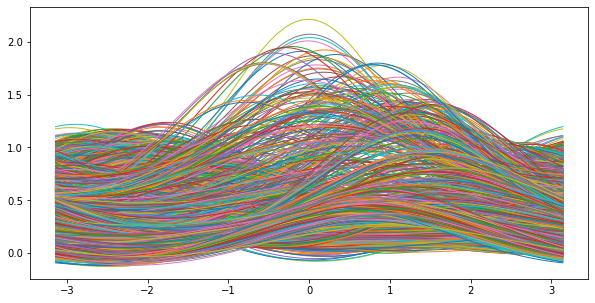

In [128]:
x = np.linspace(-np.pi, np.pi, 1000)
plt.figure(figsize= (10,5))
for i in range(len(pd_imaging_behavior_preprocessed['F_Roi_1'])):
    plt.plot(x, vonMises_function_TQ(x,  vm_parameters[i,0],vm_parameters[i,1],vm_parameters[i,2]),linewidth =1)
plt.show()

In [129]:
vonMises_angle = PVA_radian_to_angle(vonMises_value_array)

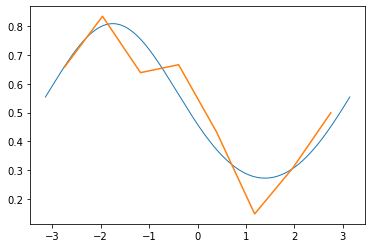

In [130]:
plt.plot(x, vonMises_function_TQ(x,  vm_parameters[100,0],vm_parameters[100,1],vm_parameters[100,2]),linewidth =1)
plt.plot(test_data_vonMises_x, dff_normalized_8_roi_shifted[:,100])

In [131]:
integrated_x_unwrapped =  fictrack_signal_decoding(integrated_x_no_series,time_array_imaging, 10, already_radian = True)
Forward_velocity = np.gradient(integrated_x_unwrapped)/volume_time
Forward_speed_radian = np.abs(Forward_velocity)
Forward_speed_degrees =Forward_speed_radian * 180/np.pi

In [132]:
#plt.hist(Angular_velocity_no_series*180/np.pi, bins ='auto')
#plt.title('Angular_velocity distribution',fontsize = 30)
#plt.xlabel('Degrees',fontsize = 25)
#plt.ylabel('Counts',fontsize = 25)
#plt.show()

In [133]:
angular_speed_degrees = np.abs(Angular_velocity_no_series*180/np.pi)
#plt.hist(angular_speed_degrees, bins ='auto')
#plt.title('Angular_speed distribution',fontsize = 30)
#plt.xlabel('Degrees',fontsize = 25)
#plt.ylabel('Counts',fontsize = 25)
#plt.show()

In [134]:
#plt.hist(Forward_velocity *180/np.pi ,bins='auto')
#plt.title('Forward_velocity distribution', fontsize = 30)
#plt.xlabel('Degrees',fontsize = 25)
#plt.ylabel('Counts',fontsize = 25)
#plt.show()

In [135]:
#plt.hist(Forward_speed_degrees ,bins='auto')
#plt.title('Forward_speed distribution',fontsize = 30)
#plt.xlabel('Degrees',fontsize = 25)
#plt.ylabel('Counts',fontsize = 25)
#plt.show()

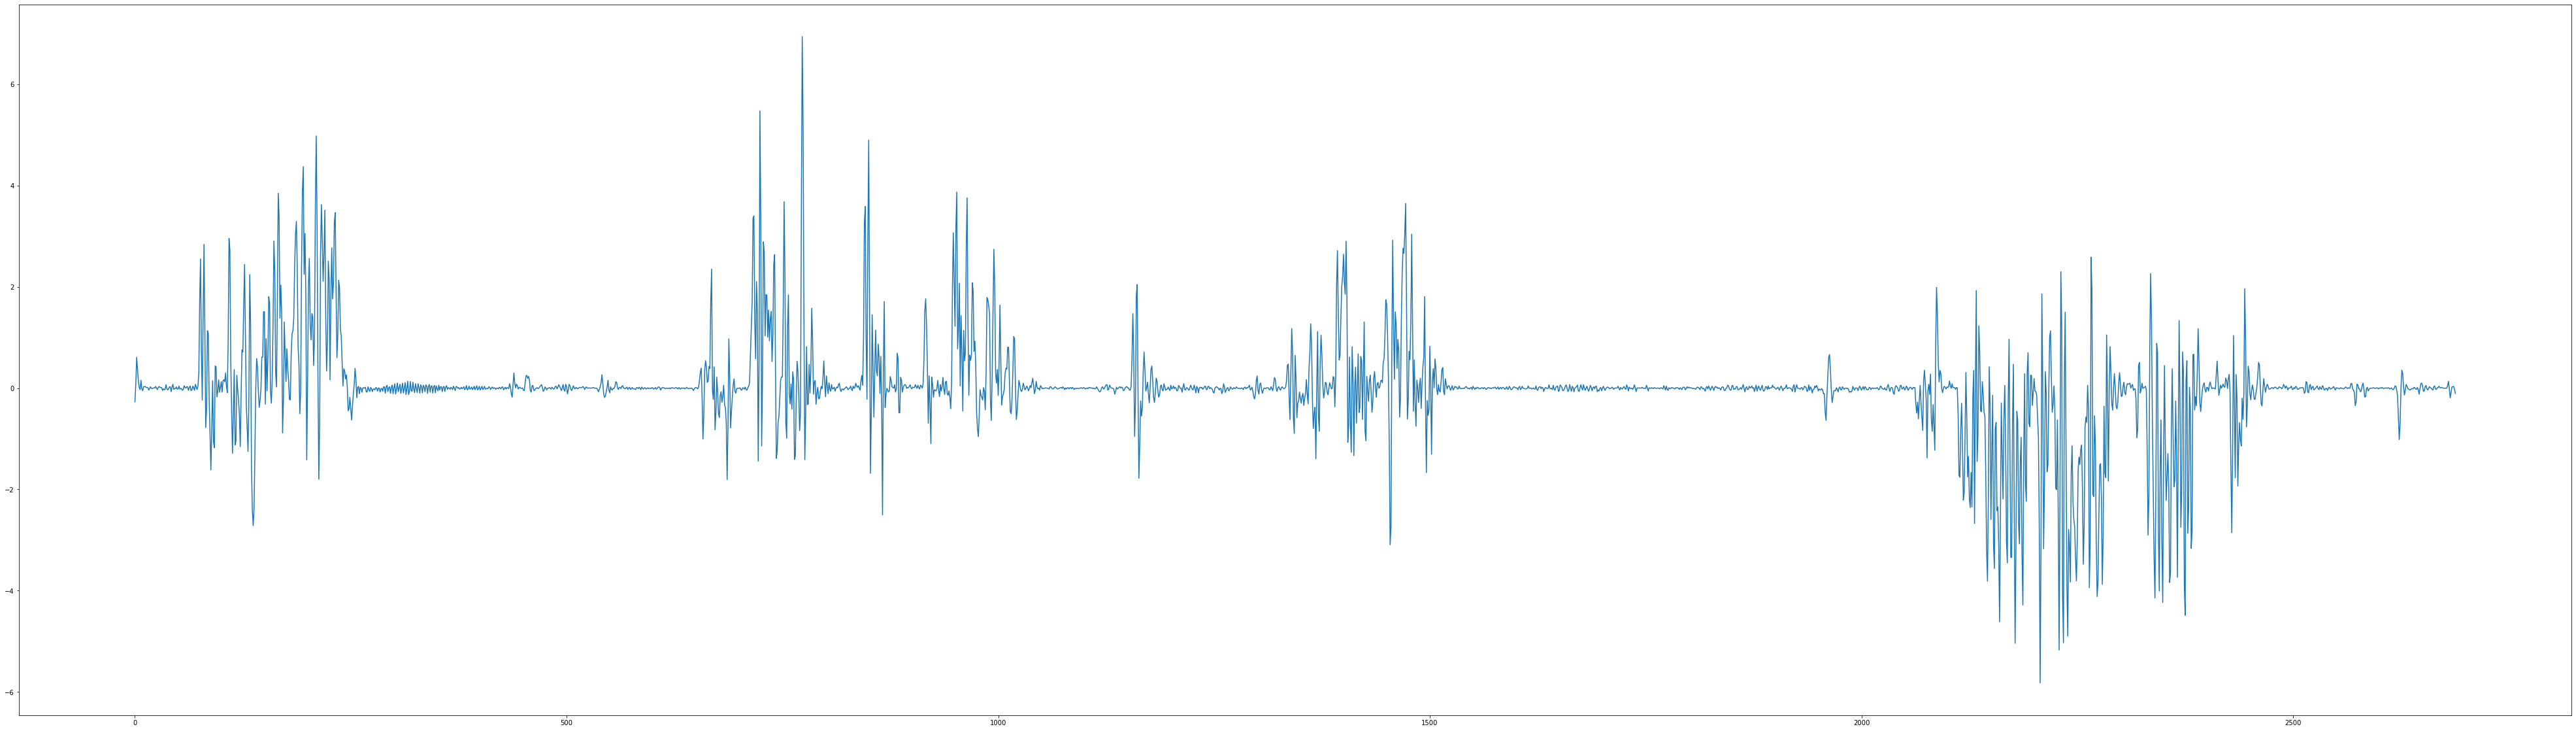

In [136]:
plt.figure(figsize= (70,20))
plt.plot(Angular_velocity)

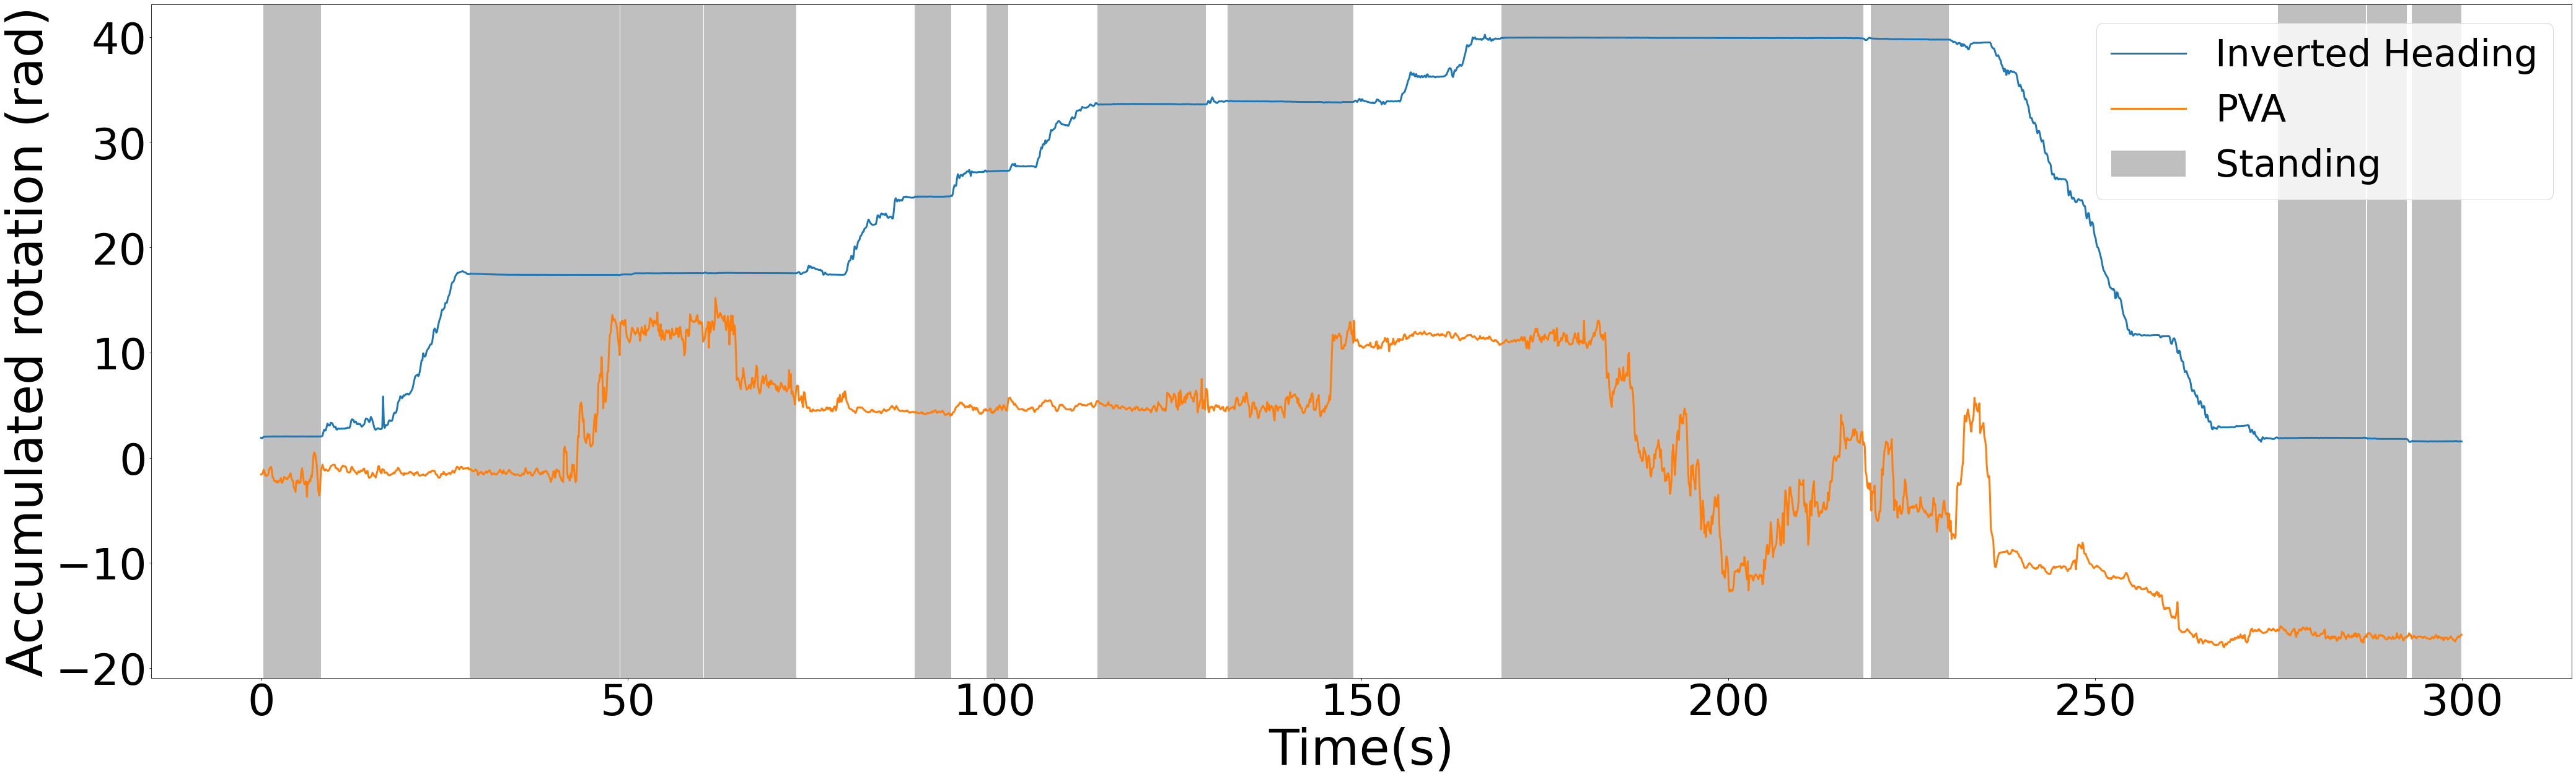

In [137]:
#find stop period and plot as shaded under unwrapped PVA/behavior
persistence_stop_index_and_length = find_stop_period_on_heading(head_velocity_array = Angular_velocity,degree_of_tolerance =15,shortest_stopFrame=int(np.ceil(3/volume_time)))
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,Unwrapped_heading ,linewidth =3)
plt.plot(time_array_imaging, PVA_Unwrapped_Radian,linewidth =3)
#plt.plot(time_array_imaging, Forward_speed_radian,linewidth =3)
plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Accumulated rotation (rad)', fontsize=80)

#Plot calculated standing period under shaded area
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
if trial_type == 0:
    plt.legend(['Inverted Heading','PVA','Standing'],fontsize=60)
else:
    plt.legend(['Bar Position','PVA','Standing'],fontsize=60)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
#plt.grid()
plt.show()

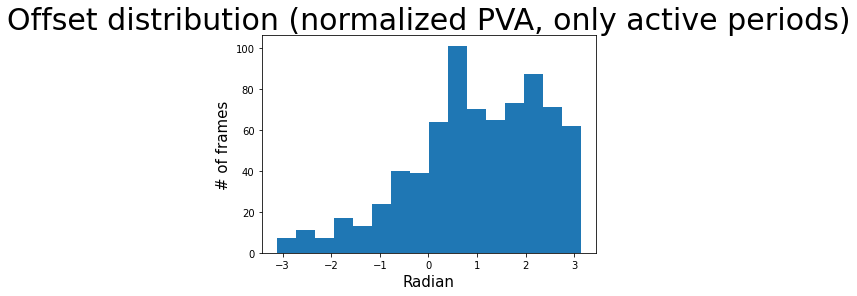

In [138]:
radian_offset_normalized = offset_calculation(Wrapped_heading, PVA_Radian, IfRadian = True)
# Bump offset excluding low velocity point
radian_offset_no_stopping_period_normalized = []
for i in range(len(Angular_velocity_no_series)):
    if np.abs(Angular_velocity_no_series[i]) >= 0.26:
        radian_offset_no_stopping_period_normalized.append(radian_offset_normalized[i])
plt.hist(radian_offset_no_stopping_period_normalized,bins='auto')
plt.title('Offset distribution (normalized PVA, only active periods)',fontsize=30)
plt.xlabel('Radian',fontsize=15)
plt.ylabel('# of frames',fontsize=15)
plt.show()

In [139]:
PVA_radian_array_normalized_offset = moving_wrapped_plot_by_offset(PVA_Radian,math.degrees(0), ifRadian =True)

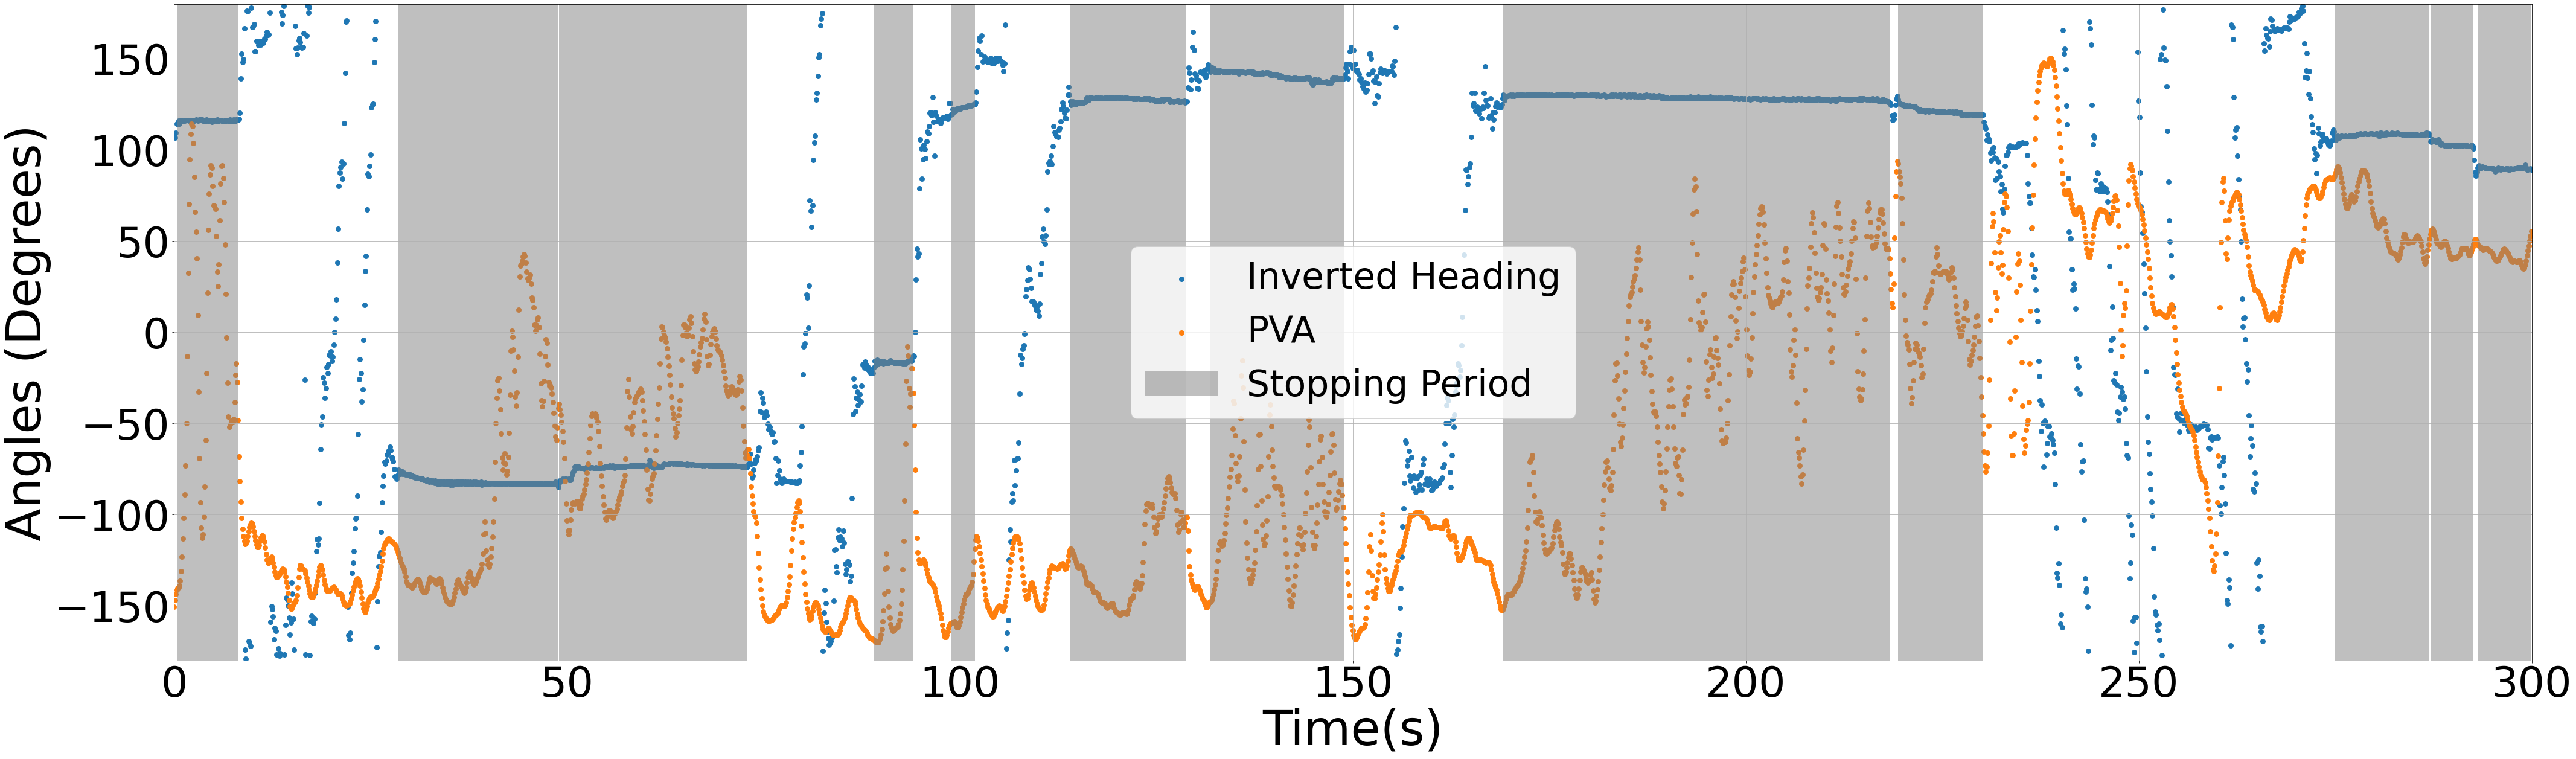

In [140]:
#Plot the stoping period as shaded under wrapped behavior
b = plt.figure(figsize= (70,20))
PVA_radian_array_normalized_offset_filtered = low_pass_filter_TQ(PVA_radian_array_normalized_offset,0.5,volume_rate)
PVA_radian_array_normalized_offset_filtered_angle = PVA_radian_to_angle(PVA_radian_array_normalized_offset_filtered)
Wrapped_heading_angle = PVA_radian_to_angle(Wrapped_heading )

plt.scatter(time_array_imaging,Wrapped_heading_angle ,linewidth =3)
plt.scatter(time_array_imaging,PVA_radian_array_normalized_offset_filtered_angle, linewidth = 3)
plt.xlabel('Time(s)', fontsize=80)
plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Angles (Degrees)', fontsize=80)

#Plot calculated standing period under shaded area
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
if trial_type == 0:
    plt.legend(['Inverted Heading','PVA','Stopping Period'],fontsize=60)
else:
    plt.legend(['Bar Position','PVA','Stopping Period'],fontsize=60, loc = 4)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylim(-180, 180)
plt.grid()
plt.show()
#b.savefig('Behavior_trace_with_PVA', format ='svg')

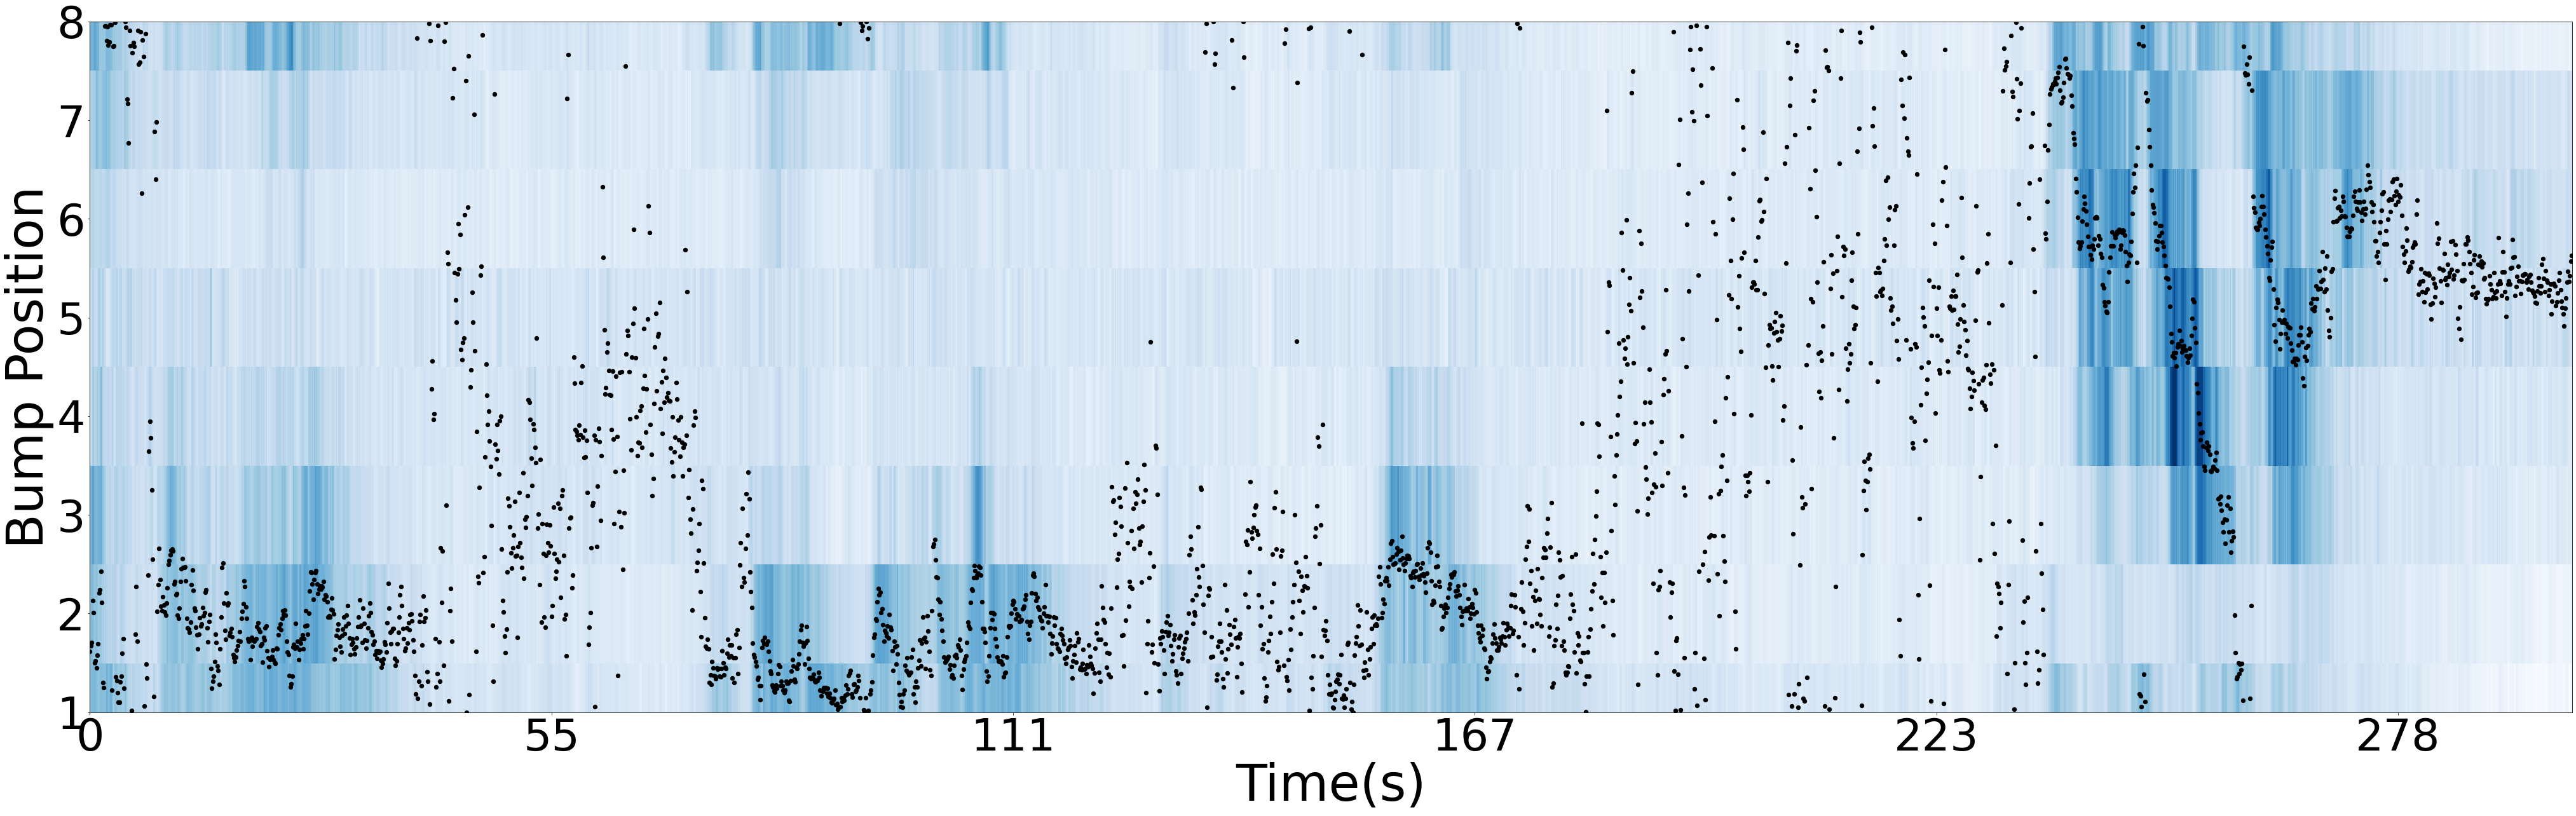

In [141]:
df_dff_in_ROI_normalized = dff_normalized_8_roi.transpose()
df_dff_in_ROI_normalized_shifted = np.zeros((np.size(df_dff_in_ROI_normalized,0),np.size(df_dff_in_ROI_normalized,1)))
df_dff_in_ROI_normalized_shifted[0,:] = df_dff_in_ROI_normalized[4,:]
df_dff_in_ROI_normalized_shifted[1,:] = df_dff_in_ROI_normalized[5,:]
df_dff_in_ROI_normalized_shifted[2,:] = df_dff_in_ROI_normalized[6,:]
df_dff_in_ROI_normalized_shifted[3,:] = df_dff_in_ROI_normalized[7,:] 
df_dff_in_ROI_normalized_shifted[4,:] = df_dff_in_ROI_normalized[0,:] 
df_dff_in_ROI_normalized_shifted[5,:] = df_dff_in_ROI_normalized[1,:] 
df_dff_in_ROI_normalized_shifted[6,:] = df_dff_in_ROI_normalized[2,:] 
df_dff_in_ROI_normalized_shifted[7,:] = df_dff_in_ROI_normalized[3,:] 
a=plt.figure(figsize= (70,20))
plt.imshow(df_dff_in_ROI_normalized_shifted, aspect= 'auto', interpolation = 'none', cmap = 'Blues')
#plt.imshow(df_dff_in_ROI_normalized_shifted, aspect= 'auto', cmap = 'Blues')
plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Bump Position', fontsize=80)
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]/volume_rate, dtype=np.int64), fontsize =70)
plt.yticks(ticks=plt.yticks()[0][0:], labels=np.array(plt.yticks()[0][0:]+1, dtype=np.int64), fontsize=70)
plt.ylim(0,7)
plt.locator_params(axis ='x',nbins = 20)
plt.scatter(np.arange(len(PVA_Angle)),7*(PVA_Angle+180)/2/180, color ='black', s = 40)
plt.show()
#a.savefig('E-PG_Bump_Heatmap__dark', format ='svg')

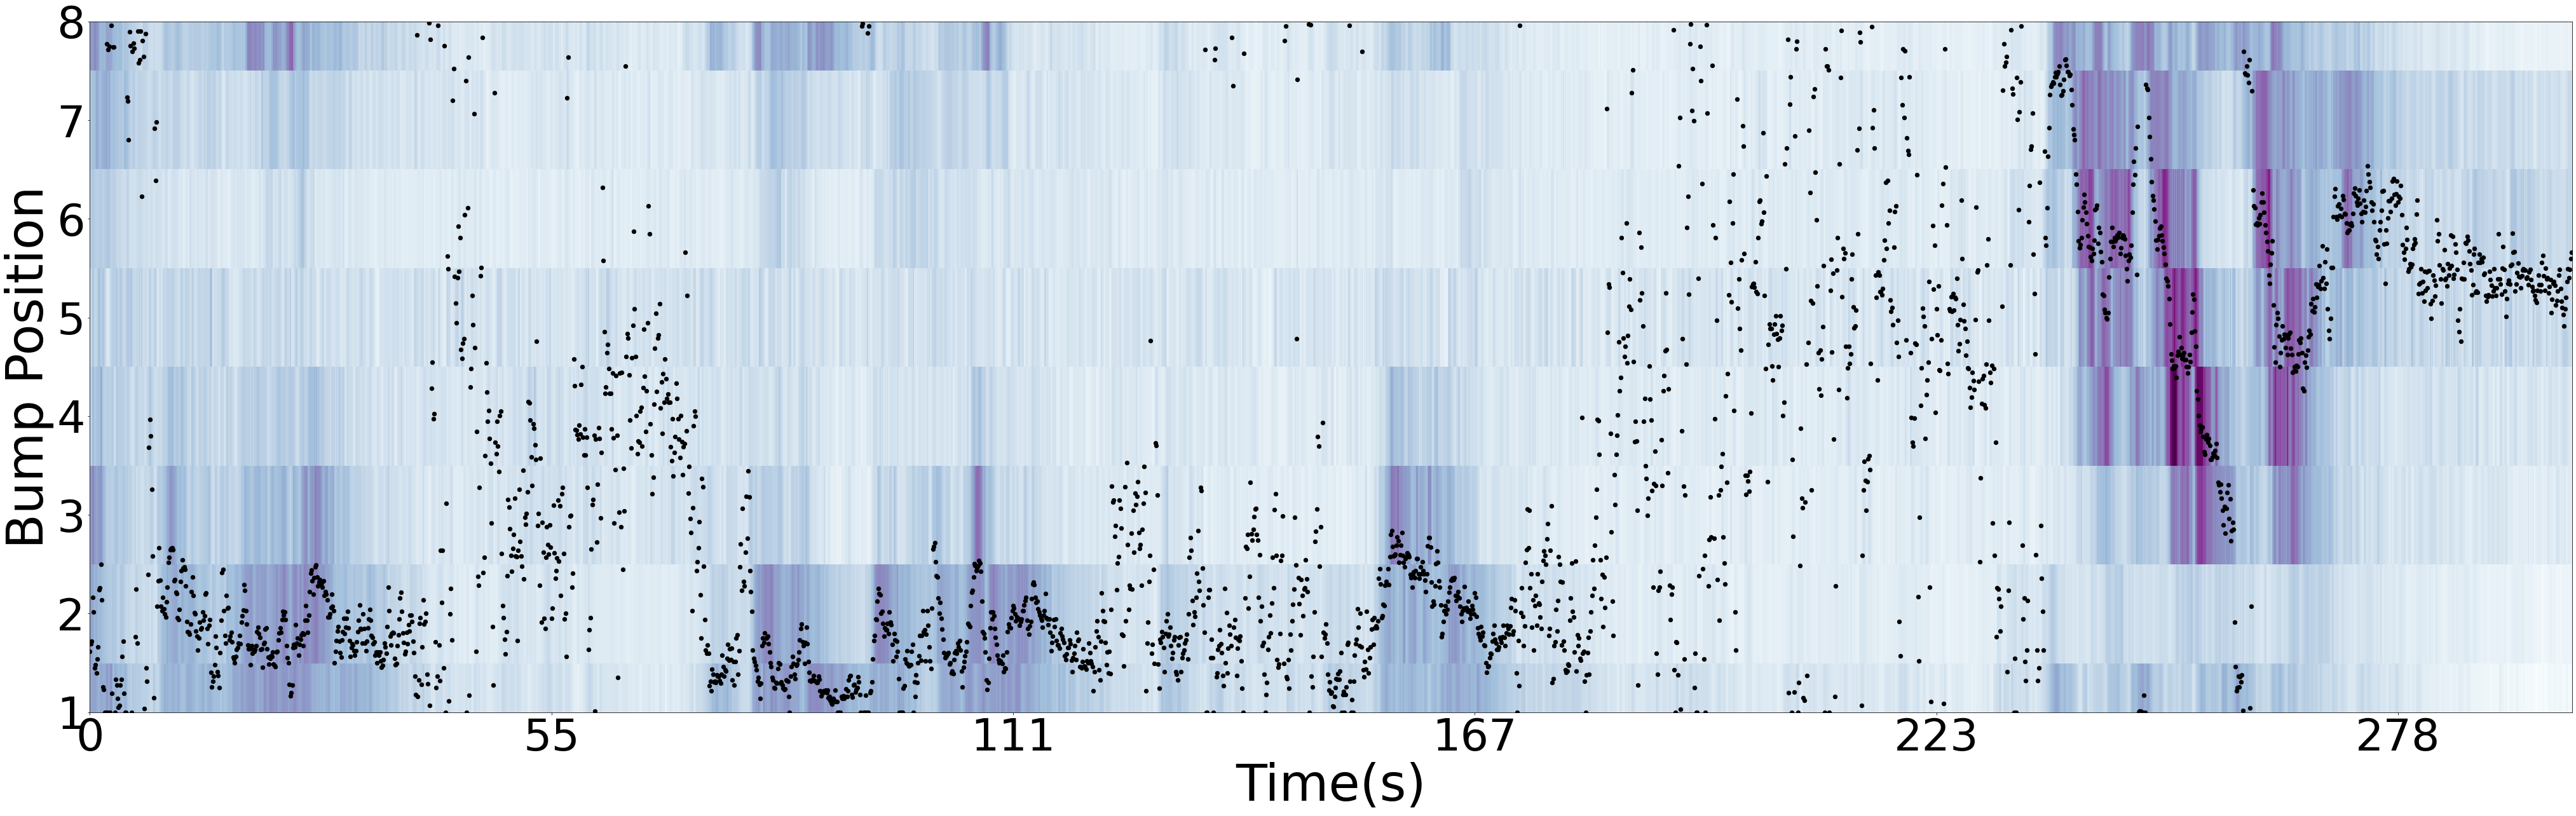

In [142]:
a=plt.figure(figsize= (70,20))
plt.imshow(df_dff_in_ROI_normalized_shifted, aspect= 'auto', interpolation = 'none', cmap = 'BuPu')
#plt.imshow(df_dff_in_ROI_normalized_shifted, aspect= 'auto', cmap = 'Blues')
plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Bump Position', fontsize=80)
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]/volume_rate, dtype=np.int64), fontsize =70)
plt.yticks(ticks=plt.yticks()[0][0:], labels=np.array(plt.yticks()[0][0:]+1, dtype=np.int64), fontsize=70)
plt.ylim(0,7)
plt.locator_params(axis ='x',nbins = 20)
plt.scatter(np.arange(len(vonMises_angle)),7*(vonMises_angle+180)/2/180, color ='black', s = 40)
plt.show()

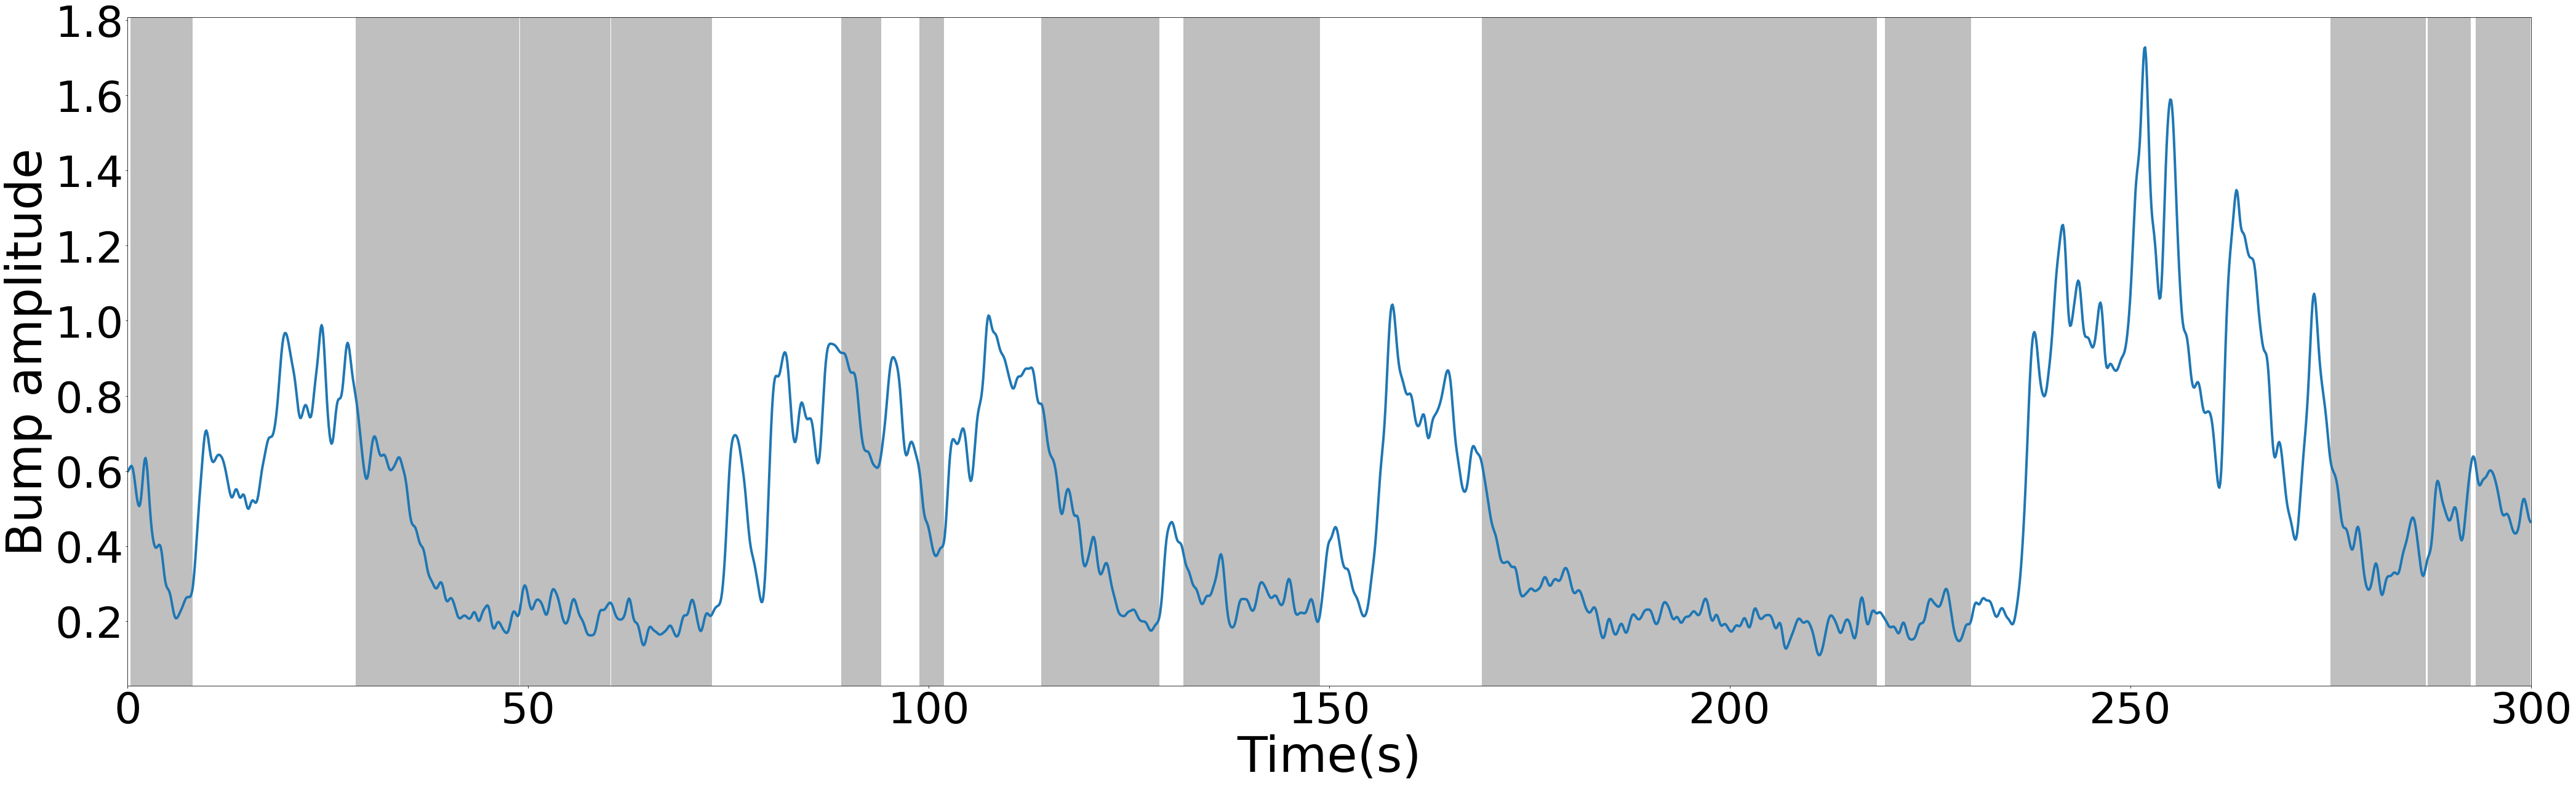

In [143]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,gaussian_filter1d(Bump_amplitude, sigma =3),linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('Bump amplitude', fontsize=80)
plt.show()

In [144]:
bump_amplitude_vonMises = np.zeros((len(vonMises_value_array)))
bump_width_vonMises = np.zeros((len(vonMises_value_array)))
for i in range(len(pd_imaging_behavior_preprocessed['F_Roi_1'])):
    bump_amplitude_vonMises[i] = (np.exp(vm_parameters[i,0]) - np.exp(-vm_parameters[i,0]))
    bump_width_vonMises[i] = 2*np.abs(np.arccos((1/vm_parameters[i,0])*np.log(0.5*(np.exp(vm_parameters[i,0])+np.exp(-vm_parameters[i,0])))))

    

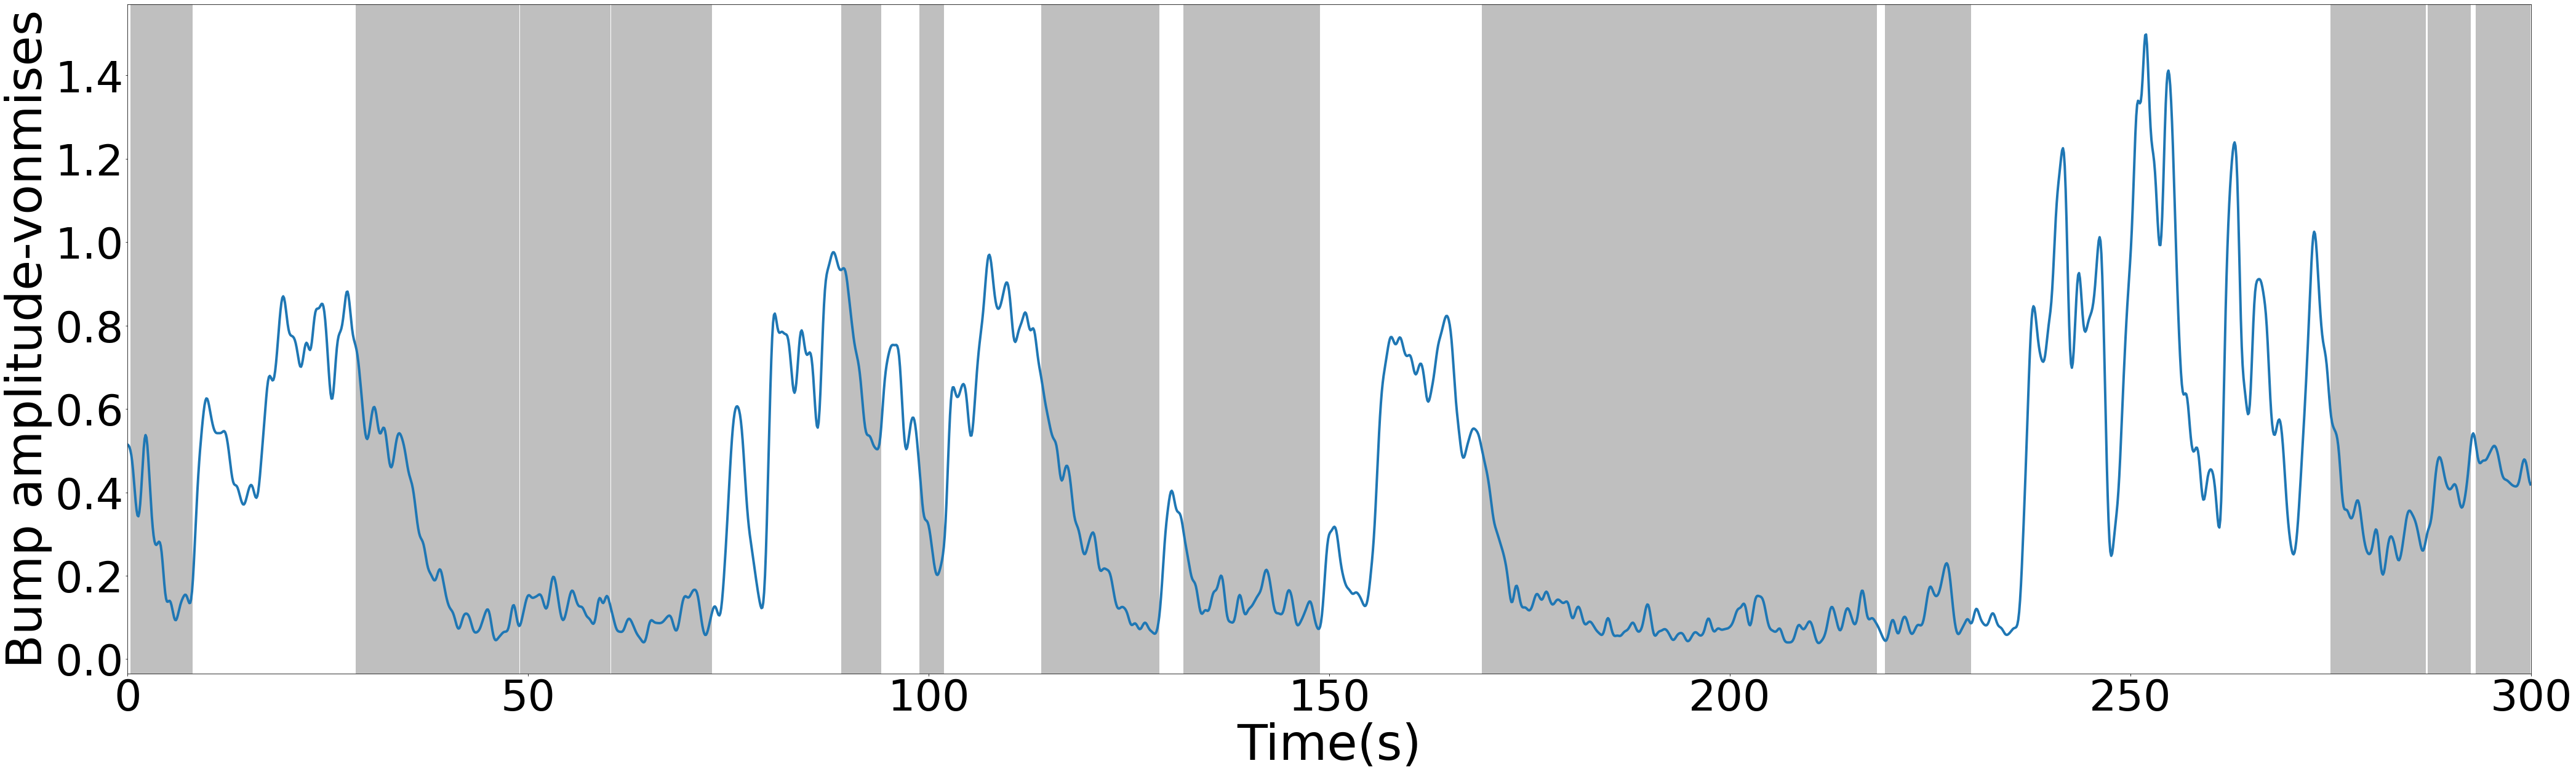

In [147]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,gaussian_filter1d(bump_amplitude_vonMises, sigma =3),linewidth =4)
#plt.plot(time_array_imaging,Bump_amplitude_vonMises,linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('Bump amplitude-vonmises', fontsize=80)
plt.show()

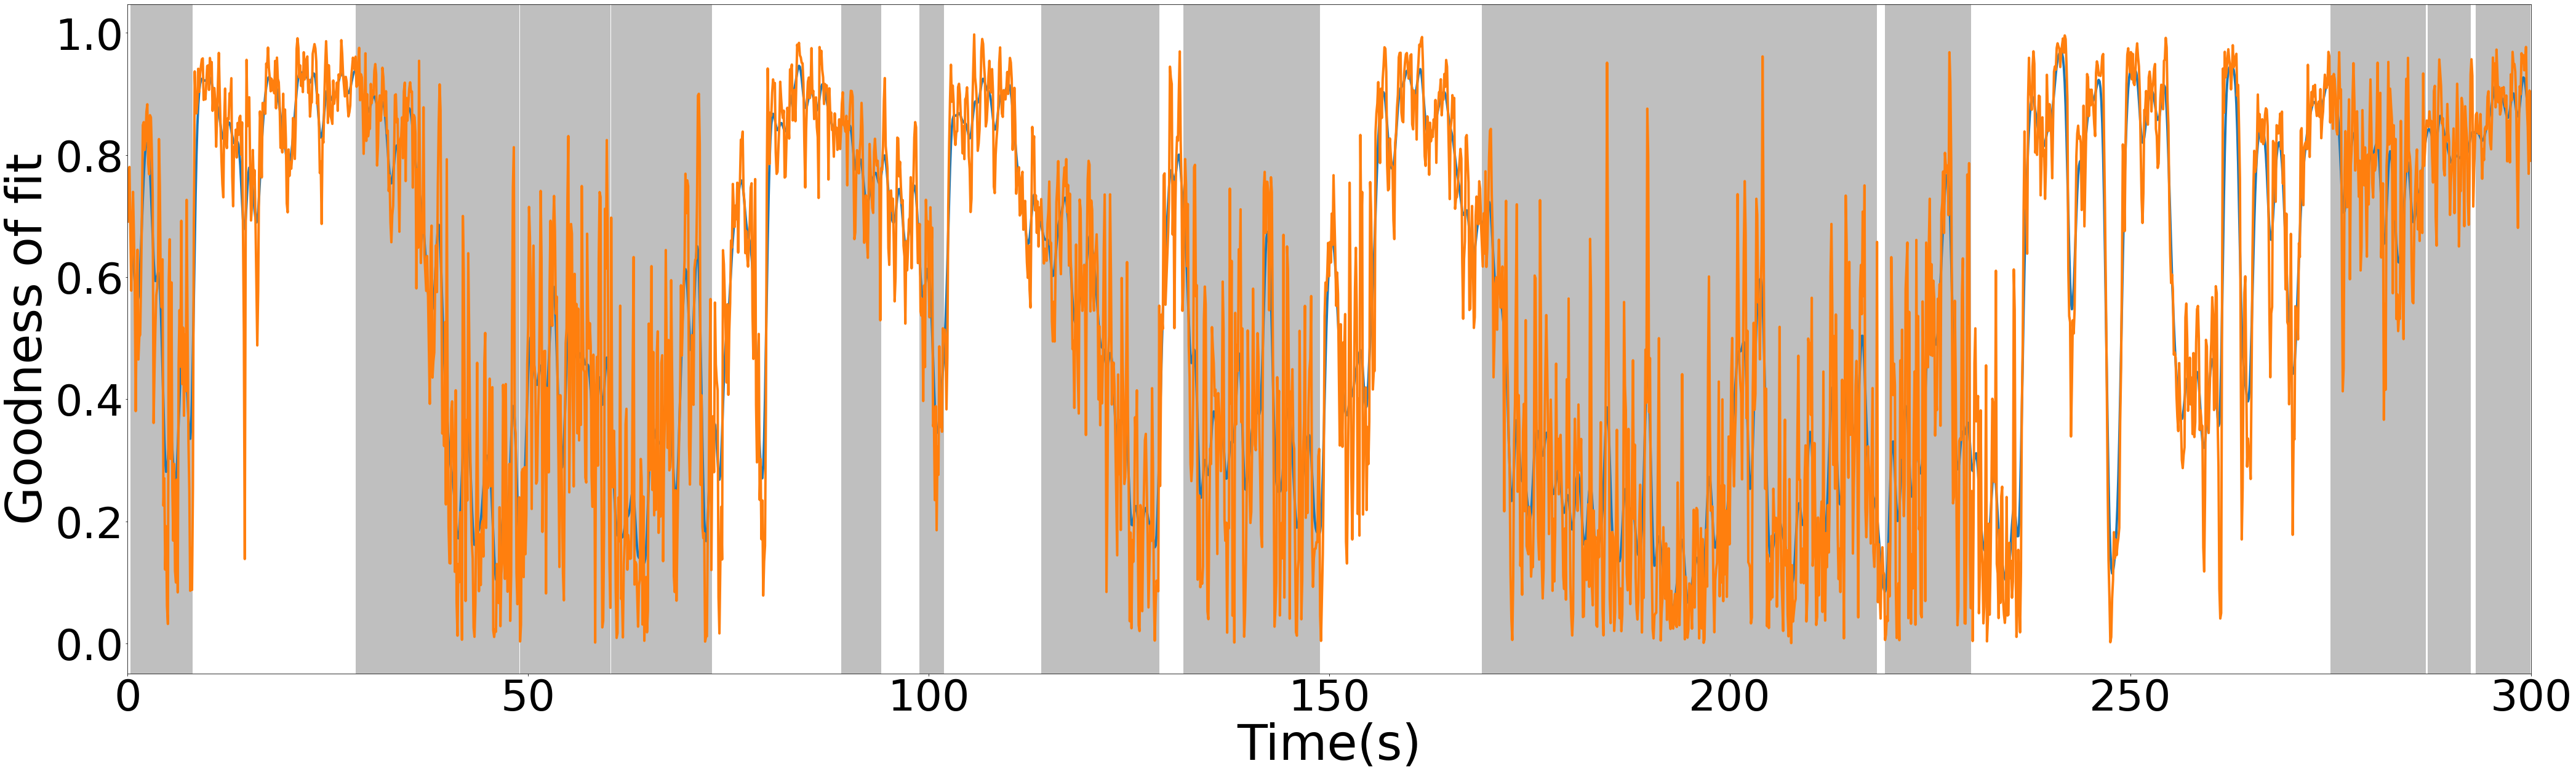

In [148]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,gaussian_filter1d(vonMises_gof_r2, sigma =3),linewidth =4)
plt.plot(time_array_imaging,vonMises_gof_r2,linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('Goodness of fit', fontsize=80)
plt.show()

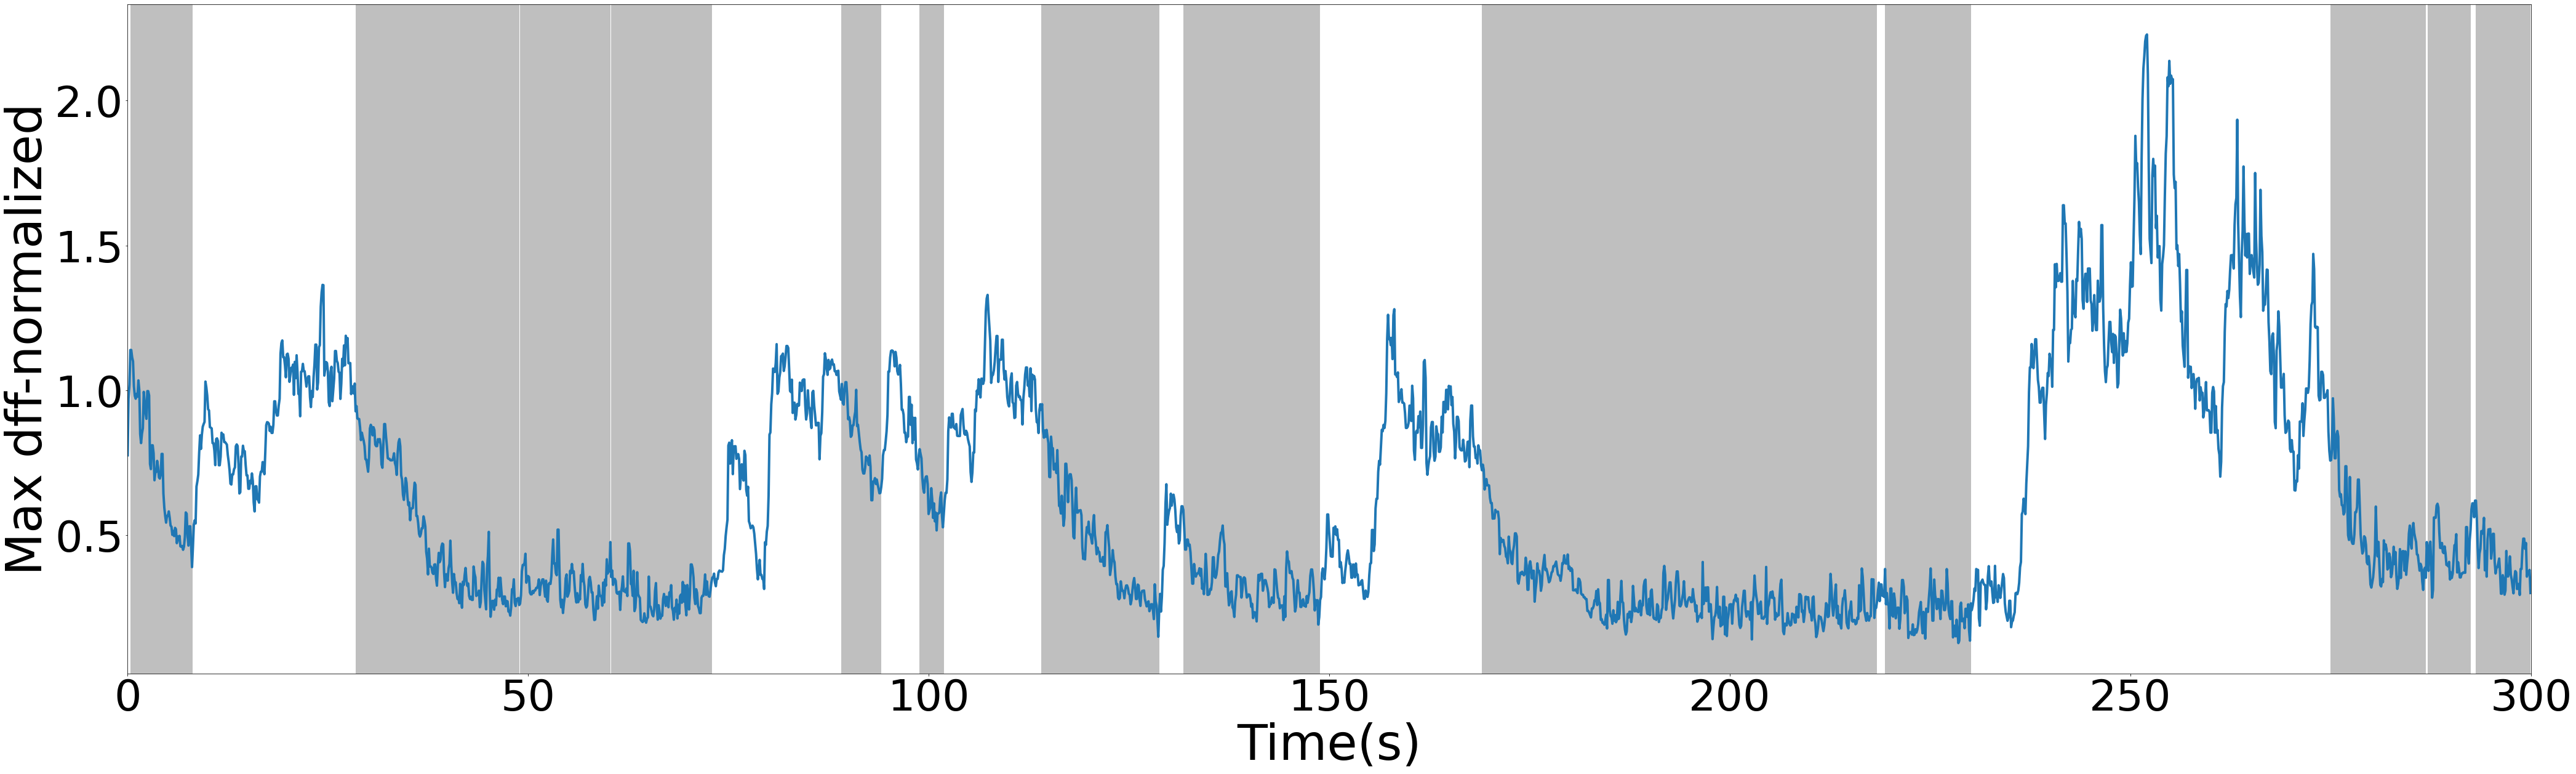

In [149]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,np.max(dff_normalized_8_roi,axis=1),linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('Max dff-normalized', fontsize=80)
plt.show()
plt.show()

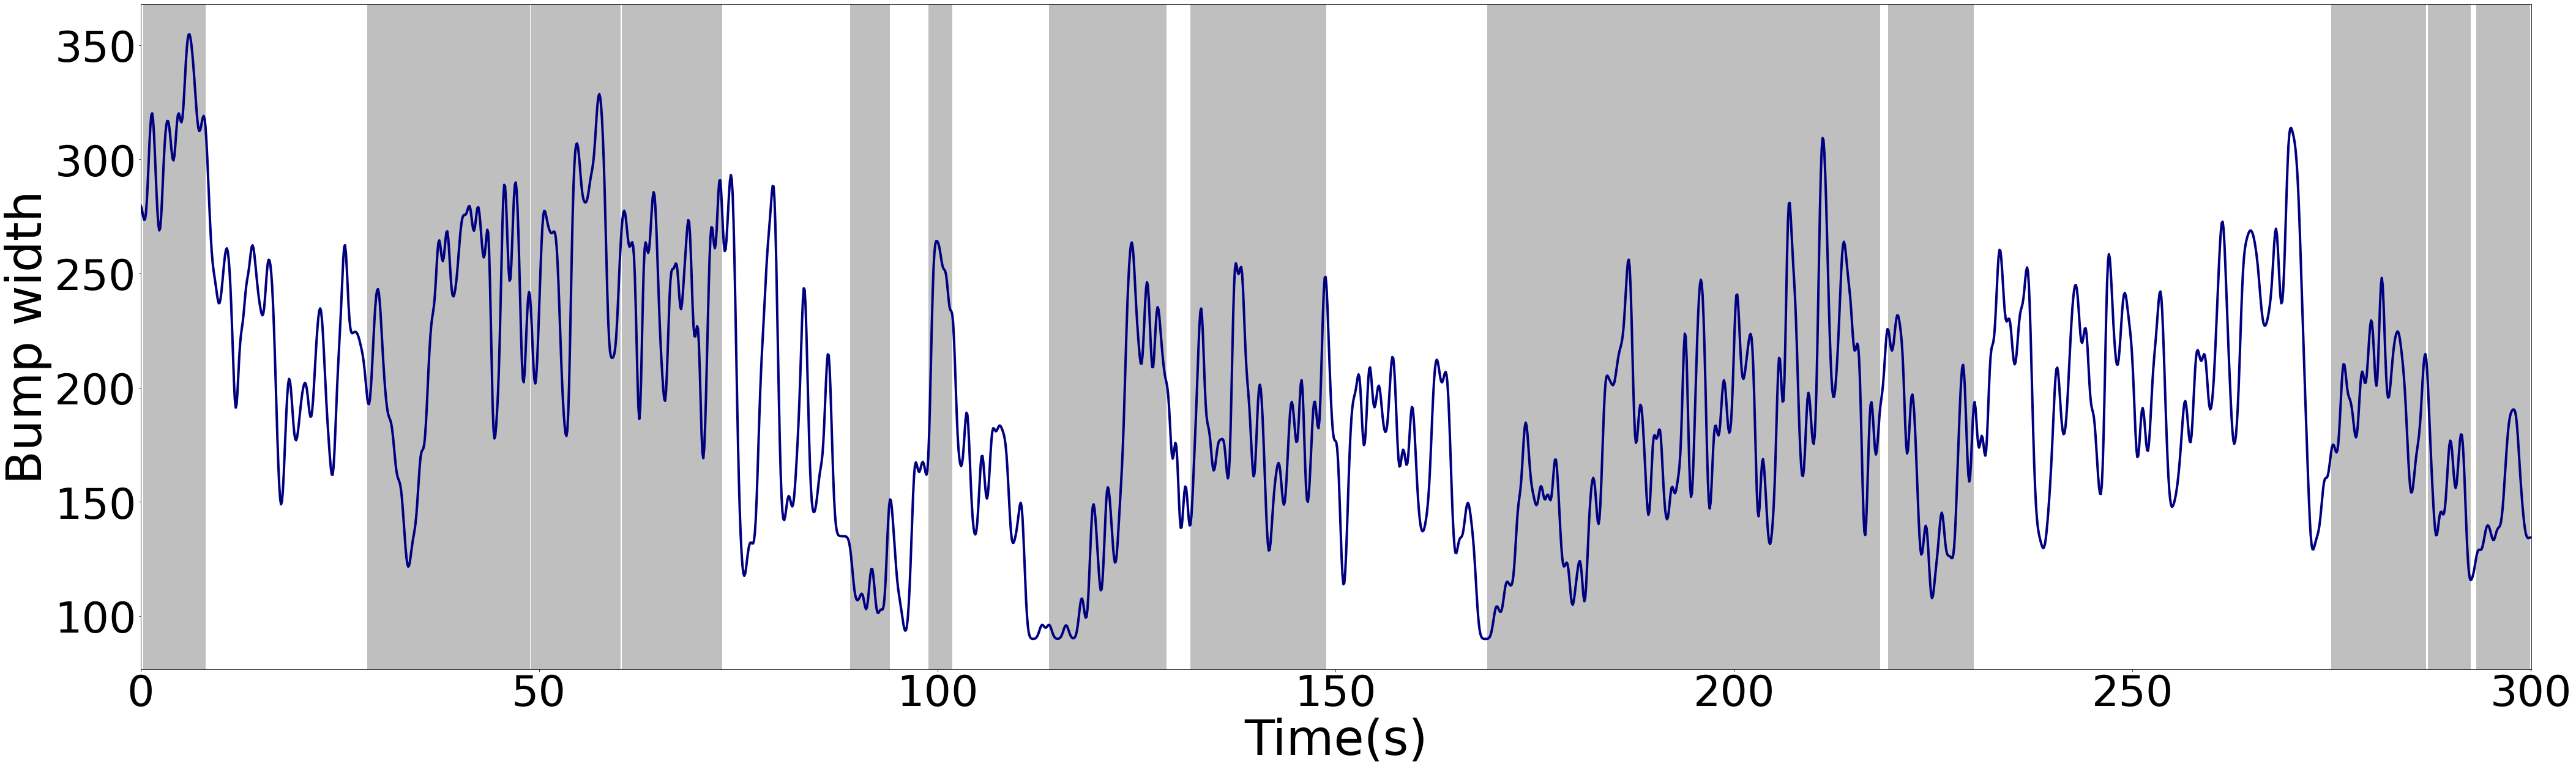

In [150]:
bump_width= calculateBumpWidth_v1(dff_normalized_8_roi,8)
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,gaussian_filter1d(bump_width, sigma =3),linewidth =4, color ='navy')
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('Bump width', fontsize=80)
plt.show()
plt.show()

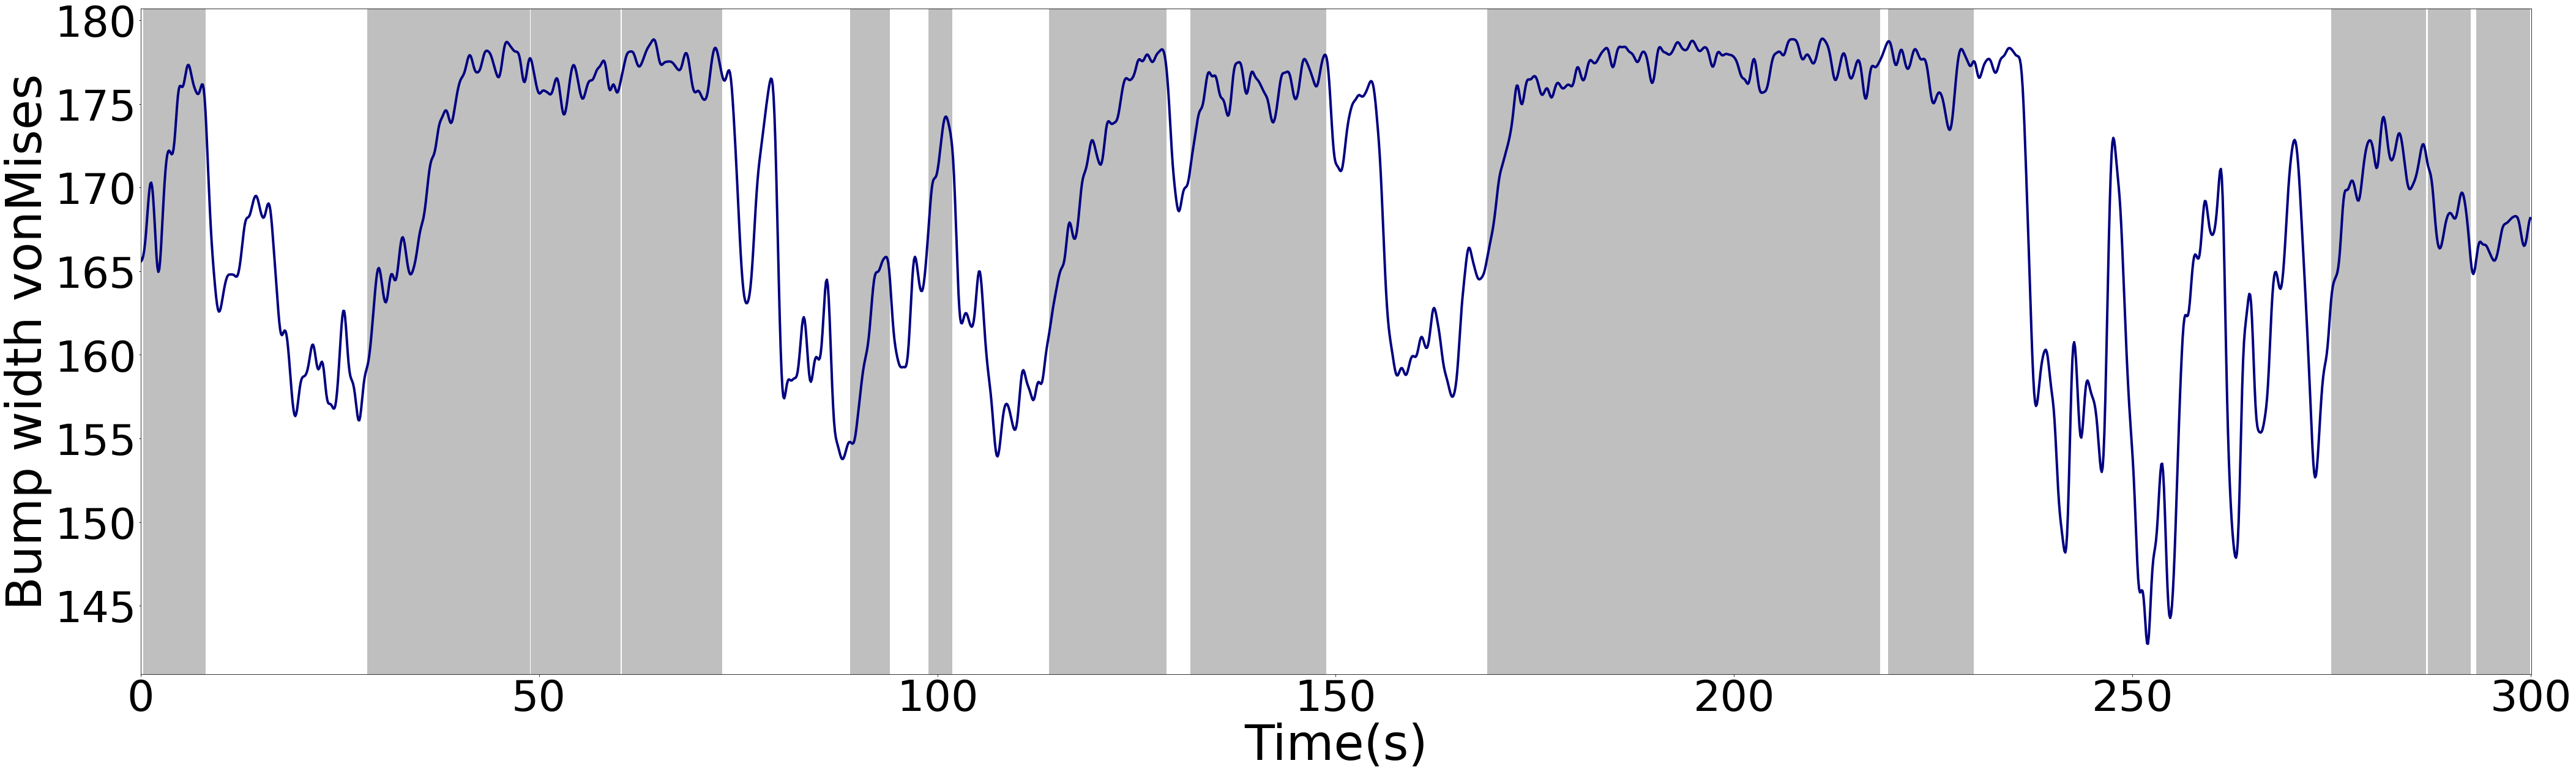

In [151]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,gaussian_filter1d(PVA_radian_to_angle(bump_width_vonMises), sigma =3),linewidth =4, color ='navy')
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('Bump width vonMises', fontsize=80)
plt.show()
plt.show()

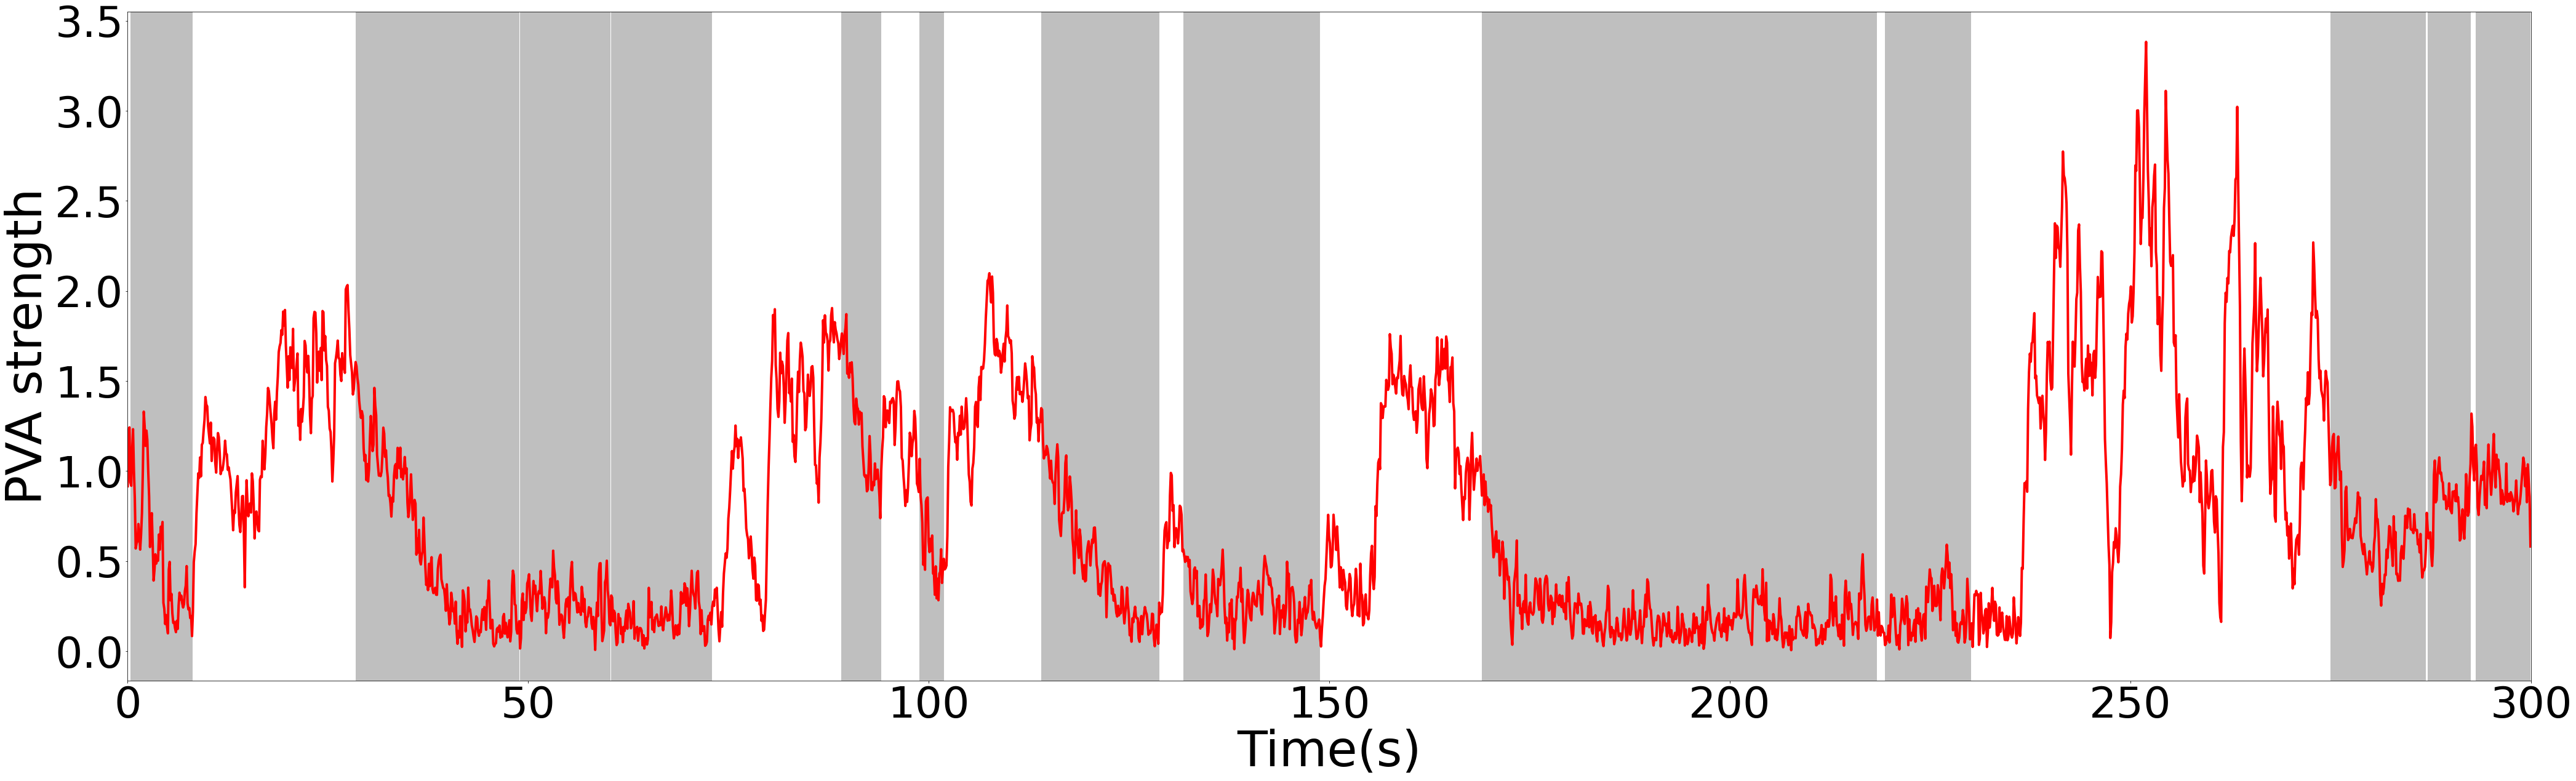

In [152]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,PVA_strength_no_series,color = 'r',linewidth =4)
#plt.plot(time_array_imaging,PVA_strength_no_series,color = 'b',linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('PVA strength', fontsize=80)
plt.show()

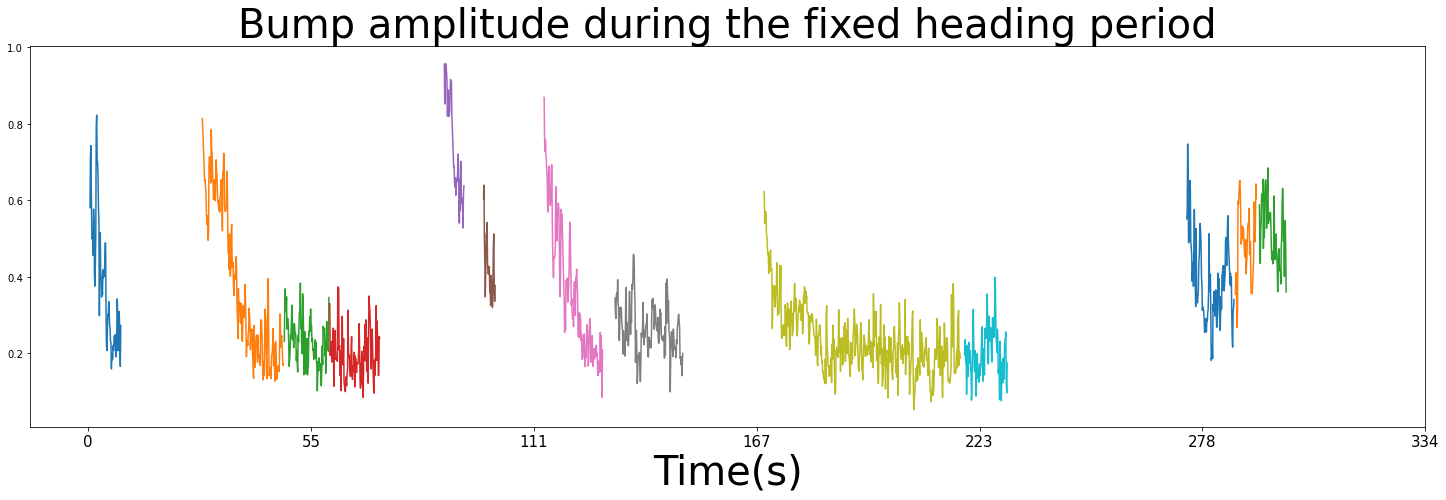

In [153]:
#Check bump amplitude during the time of fixed-heading period
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(Bump_amplitude[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.title('Bump amplitude during the fixed heading period', fontsize =40)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=15)
plt.xlabel('Time(s)', fontsize=40)
plt.show()

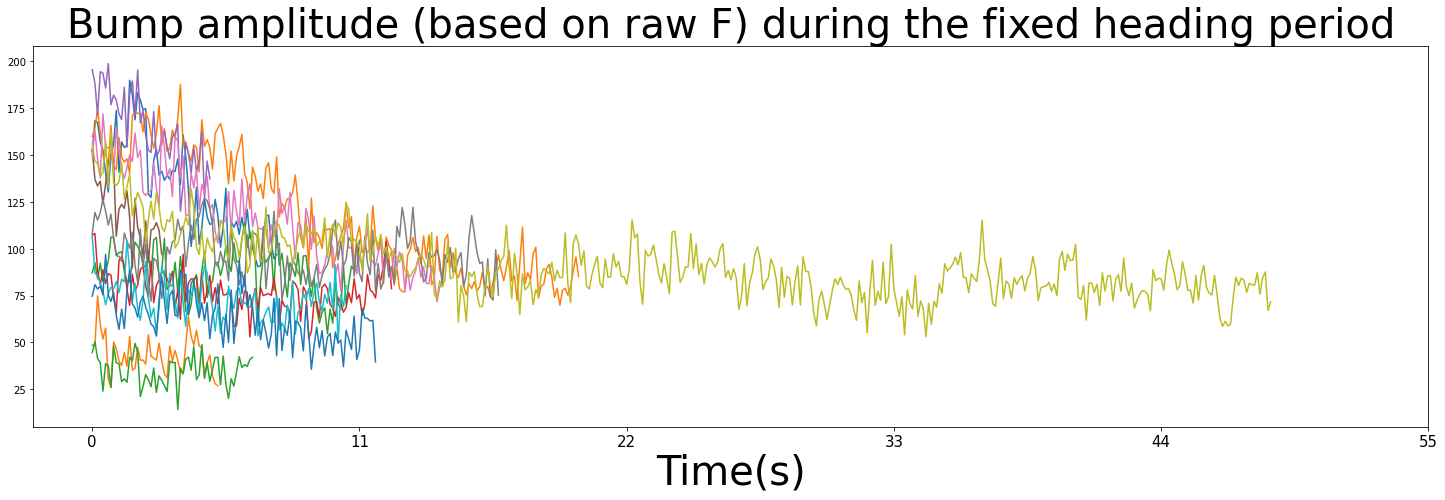

In [154]:
#Check bump amplitude (based on raw F) during the time of fixed-heading period
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(bump_amplitude_F[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.title('Bump amplitude (based on raw F) during the fixed heading period', fontsize =40)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=15)
plt.xlabel('Time(s)', fontsize=40)
plt.show()

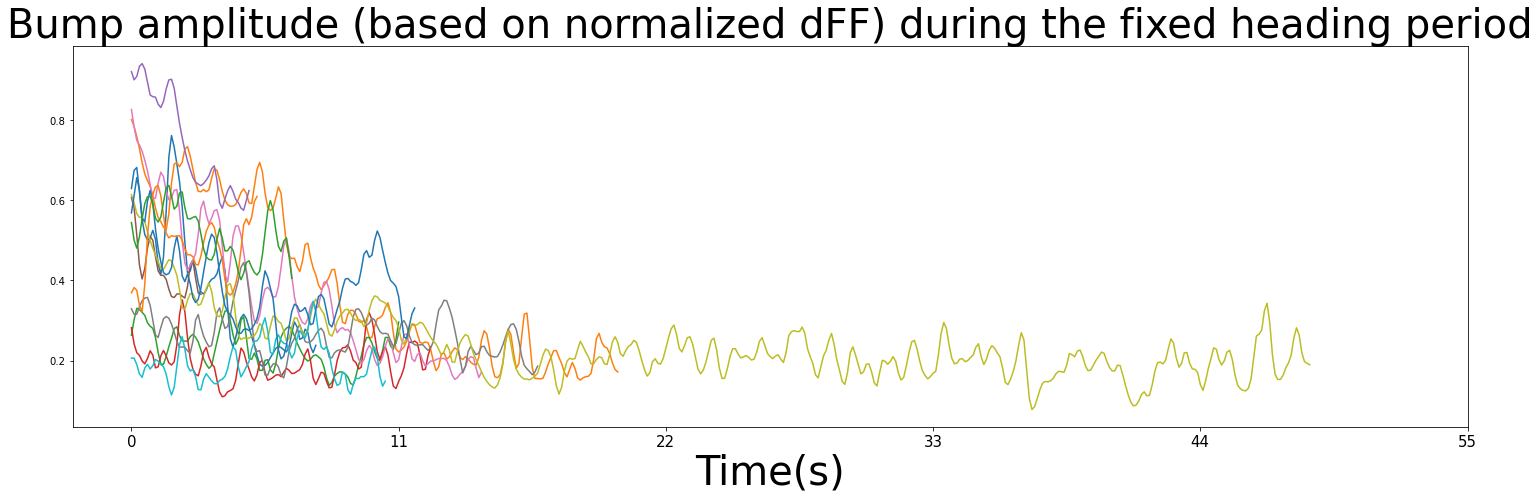

In [155]:
#Check bump amplitude (based on raw F) during the time of fixed-heading period
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(gaussian_filter1d(Bump_amplitude_no_series[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1],sigma =1))
plt.title('Bump amplitude (based on normalized dFF) during the fixed heading period', fontsize =40)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=15)
plt.xlabel('Time(s)', fontsize=40)
plt.show()

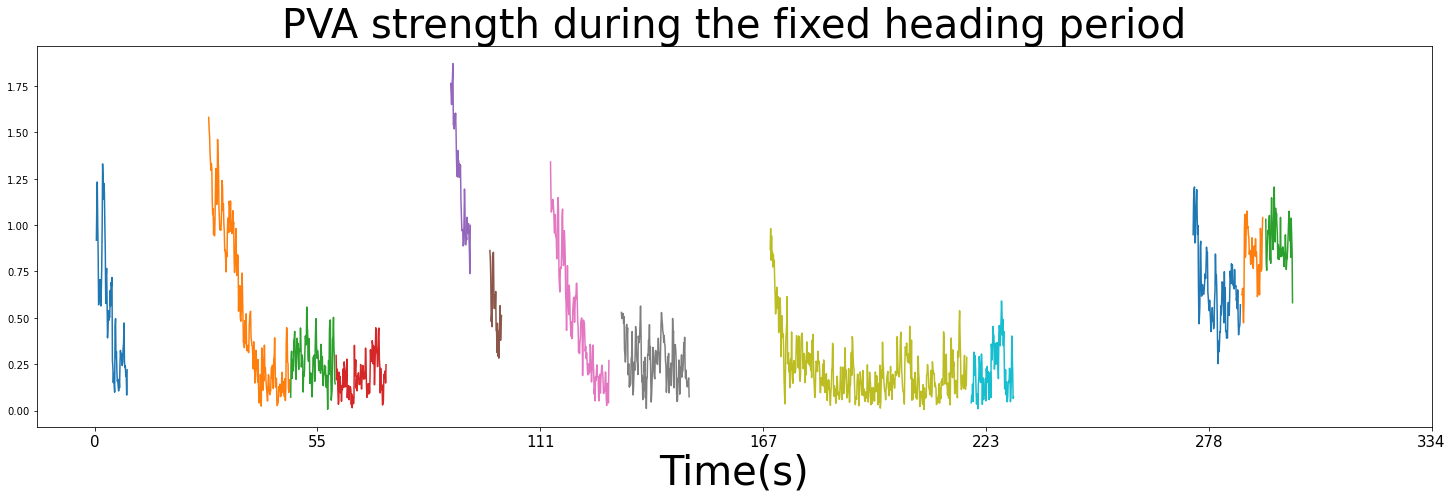

In [156]:
#Check PVA strength during the time of fixed-heading period
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(PVA_strength[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=15)
plt.title('PVA strength during the fixed heading period', fontsize =40)
plt.xlabel('Time(s)', fontsize=40)
plt.show()
    

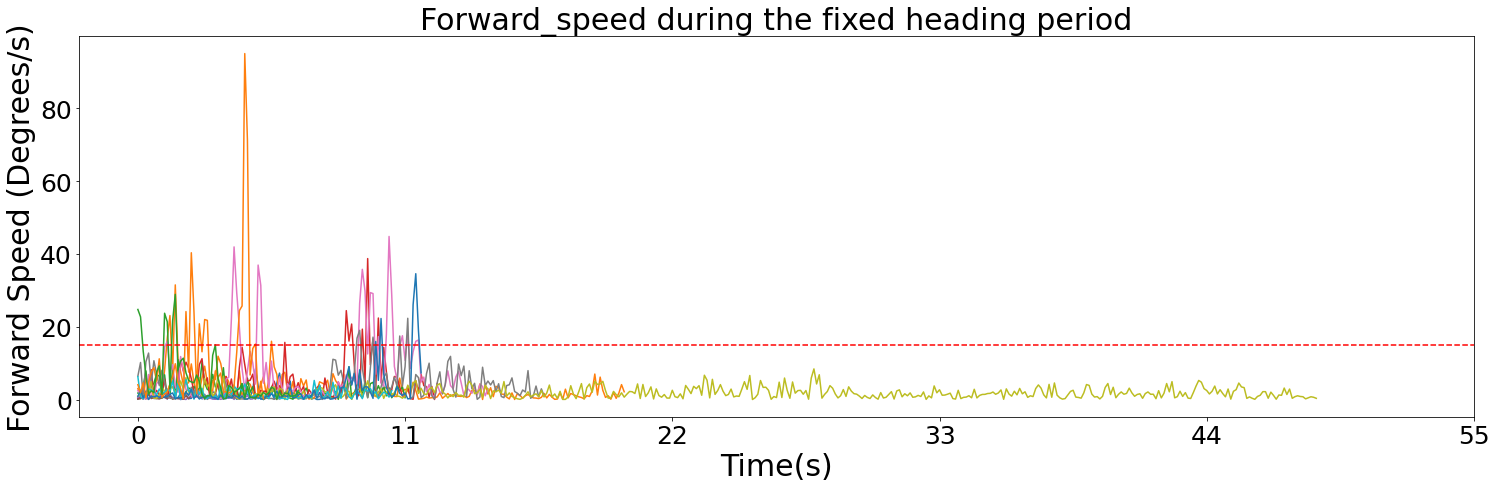

In [157]:
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(Forward_speed_degrees[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.title('Forward_speed during the fixed heading period', fontsize =30)
plt.axhline(y= 15, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=30)
plt.yticks(fontsize=25)
plt.ylabel('Forward Speed (Degrees/s)', fontsize=30)
plt.show()
    

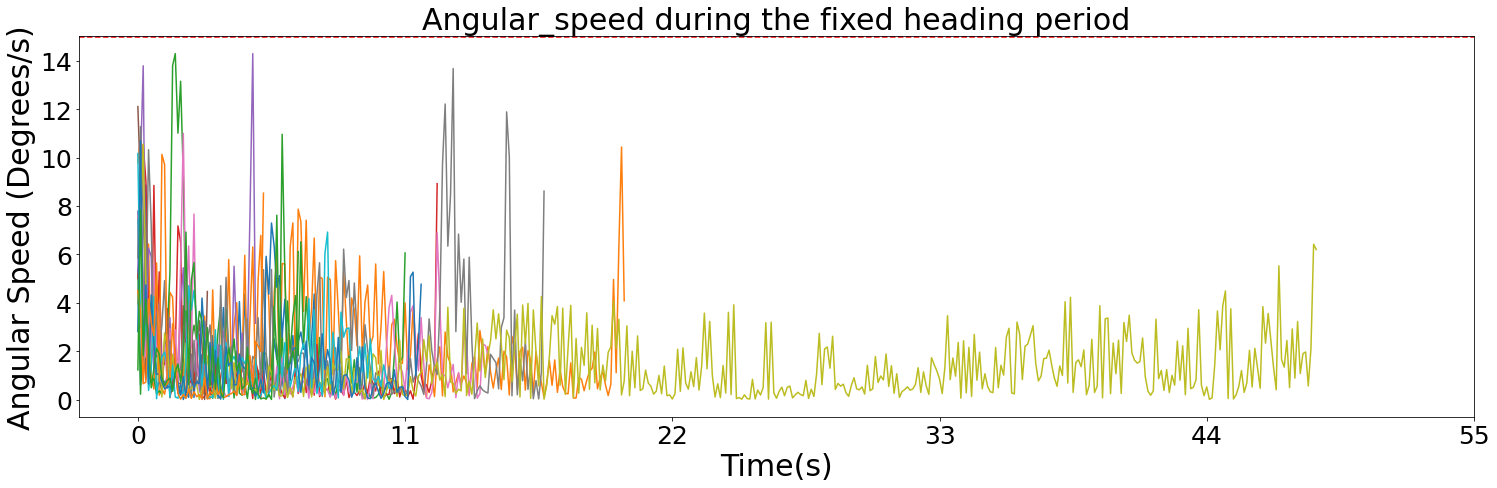

In [158]:
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(angular_speed_degrees[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.title('Angular_speed during the fixed heading period', fontsize =30)
plt.axhline(y= 15, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=30)
plt.yticks(fontsize=25)
plt.ylabel('Angular Speed (Degrees/s)', fontsize=30)
plt.show()
    

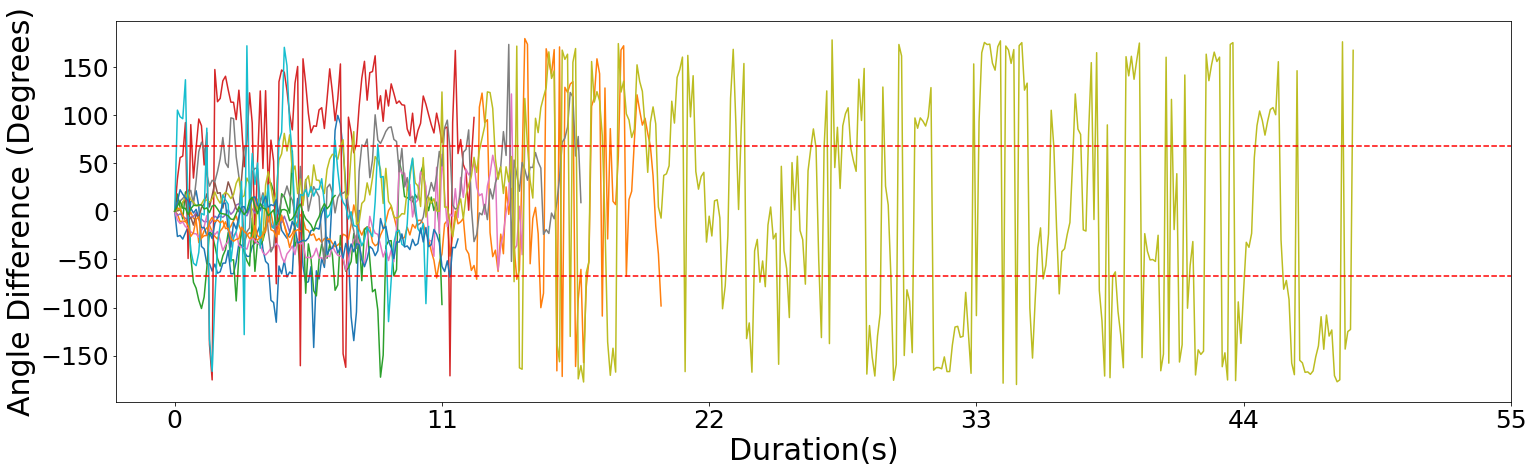

In [159]:
#Calculate annd plot difference throughout the stop period
difference_during_stop = []
current_difference_during_stop = []
current_forward_speed_during_stop = []
forward_speed_during_stop =[]
plt.figure(figsize= (25,7))
for current_index in range(len(persistence_stop_index_and_length)):
    current_stop_PVA = PVA_Angle_no_series[persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1]
    current_stop_start_index = persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1
    current_difference_during_stop = PVA_Angle_no_series[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1] - current_stop_PVA
    current_forward_speed_during_stop = Forward_speed_degrees[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1]
    #Modify the value so angle difference will never be different more than 180 degrees
    for j in range(len(current_difference_during_stop)):
        if np.abs(current_difference_during_stop[j]) > 180:
            if current_difference_during_stop[j] < 0:
                current_difference_during_stop[j] =  current_difference_during_stop[j] + 360
            else:
                current_difference_during_stop[j] =  current_difference_during_stop[j] - 360
    
    difference_during_stop.append(current_difference_during_stop)
    forward_speed_during_stop.append(current_forward_speed_during_stop)
    plt.plot(current_difference_during_stop)

max_length = 0
for i in range(len(difference_during_stop)):
    if max_length < len(difference_during_stop[i]):
        max_length = len(difference_during_stop[i])

time_array_PVA_difference_stop = np.arange(max_length)/volume_rate
plt.axhline(y= 67.5, color = 'r',linestyle ='--')
plt.axhline(y= -67.5, color = 'r',linestyle ='--')
plt.ylabel('Angle Difference (Degrees)', fontsize=30)
plt.xlabel('Duration(s)',fontsize =30)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.yticks(fontsize=25)
plt.show()
    

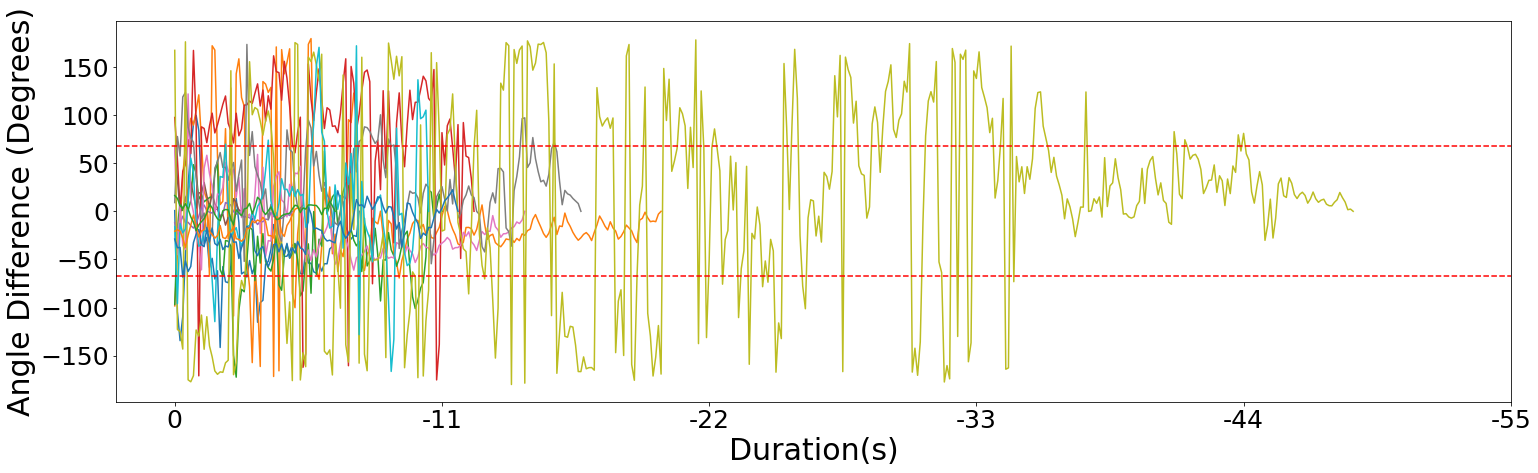

In [160]:
#Plot the reverse of difference during fixed heading period (align at the restart)
plt.figure(figsize= (25,7))
for i in range(len(difference_during_stop)):
    plt.plot(np.flip(difference_during_stop[i]))
             
max_length = 0
for i in range(len(difference_during_stop)):
    if max_length < len(difference_during_stop[i]):
        max_length = len(difference_during_stop[i])

time_array_PVA_difference_stop = np.arange(max_length)/volume_rate
plt.axhline(y= 67.5, color = 'r',linestyle ='--')
plt.axhline(y= -67.5, color = 'r',linestyle ='--')
plt.ylabel('Angle Difference (Degrees)', fontsize=30)
plt.xlabel('Duration(s)',fontsize =30)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/-volume_rate, dtype=np.int64), fontsize=25)
plt.yticks(fontsize=25)
plt.show()

In [161]:
# UPDATE FlyTrial, GENOTYPE, and trialType
PVA_angle_at_stop = PVA_during_stopPeriod(stop_index_array = persistence_stop_index_and_length, PVA_array =PVA_Angle_no_series, volume_time=volume_time)
PVA_angle_at_stop.insert(0,'FlyTrial','TQfly005-006')
PVA_angle_at_stop.insert(1,'Genotype','unsure')
PVA_angle_at_stop.insert(2,'TrialType','cl')
PVA_angle_at_stop

FlyTrial Genotype TrialType  Period_duration  PVA_before_stop  \
0   TQfly005-006   unsure        cl          7.81060      -128.021976   
1   TQfly005-006   unsure        cl         20.41914      -119.617959   
2   TQfly005-006   unsure        cl         11.26958       -47.919241   
3   TQfly005-006   unsure        cl         12.60854      -128.007671   
4   TQfly005-006   unsure        cl          5.02110      -167.444203   
5   TQfly005-006   unsure        cl          3.01266      -160.461836   
6   TQfly005-006   unsure        cl         14.72856      -109.065552   
7   TQfly005-006   unsure        cl         17.07174      -159.986184   
8   TQfly005-006   unsure        cl         49.31836      -153.451825   
9   TQfly005-006   unsure        cl         10.71168        14.093923   
10  TQfly005-006   unsure        cl         11.93906        82.513014   
11  TQfly005-006   unsure        cl          5.35584        63.847548   
12  TQfly005-006   unsure        cl          6.80638        41.699168   

    PVA_at_restart  PVA_100ms_before_restart  PVA_500ms_before_restart  \
0      -127.265801                127.441139               -171.935407   
1       142.123933               -163.931565                -51.891427   
2      -144.687453                -65.426535                -33.176779   
3       -30.550294                -74.257957                -79.515135   
4      -179.079718                170.909464               -179.263158   
5       -93.609284               -127.218838               -148.311211   
6       -40.905757               -154.108183               -148.728859   
7      -150.910618                -82.275658                -36.543651   
8        13.734617                 83.808172                 22.605839   
9        -1.729706                -81.807231                 -4.047145   
10       53.707998                 44.681617                 31.090628   
11       43.170427                 44.716363                 26.338964   
12       58.083414                 55.058043                 49.593839   

    PVA_in_middle  PVA_2s_before_restart  PVA_3s_after_stop  \
0      179.943183              90.551037        -169.803085   
1     -129.128776            -112.627013        -150.007404   
2      -81.728236            -108.485177         -91.601469   
3      -42.003627             -27.642148         -81.728604   
4     -167.668122            -172.106724        -170.612546   
5     -155.911979            -166.782814         -93.609284   
6     -159.494388             -92.797531        -146.806401   
7      -85.885774             -98.933580         163.845430   
8      154.969961              39.781948        -137.327760   
9       31.677573              50.266118        -113.990500   
10      65.108192              53.414899          87.420689   
11      34.679460              49.056903          43.064825   
12      46.152116              31.890216          38.322303   

    PVA_5s_after_stop  PVA_10s_after_stop  PVA_35s_after_stop  
0          166.959033                 NaN                 NaN  
1         -142.675049         -133.293635                 NaN  
2           14.828935          -38.046389                 NaN  
3          -43.429891          -26.105806                 NaN  
4         -179.079718                 NaN                 NaN  
5                 NaN                 NaN                 NaN  
6         -145.154025         -114.899963                 NaN  
7         -148.532026         -144.320867                 NaN  
8         -112.991116          -98.871592            0.177334  
9           73.639771           69.364975                 NaN  
10          72.162847           53.414899                 NaN  
11          35.902623                 NaN                 NaN  
12          33.929393                 NaN                 NaN

In [162]:
Forward_speed_at_stop = forwrad_speed_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,forward_speed_array=Forward_speed_degrees, volume_time=volume_time)
Forward_speed_at_stop

forward_speed_before_stop  forward_speed_at_restart  \
0                    0.156109                  0.270691   
1                    3.029296                  2.121625   
2                    1.772849                  0.496897   
3                    0.328681                  4.348183   
4                    0.516058                  0.988935   
5                    0.096933                  1.015936   
6                    2.414958                  2.968842   
7                    6.438585                  1.021852   
8                    0.905982                  0.327310   
9                    6.263402                  2.429414   
10                   0.880946                  7.308624   
11                   4.073875                  0.192575   
12                  24.733210                  2.511027   

    forward_speed_100ms_before_restart  forward_speed_500ms_before_restart  \
0                             0.042265                            0.098444   
1                             4.092057                            1.867422   
2                             3.490500                            1.542800   
3                             0.015852                            3.538622   
4                             0.157493                            0.392427   
5                             0.027900                            0.693584   
6                             1.030594                            1.280738   
7                             2.929096                            1.013239   
8                             0.613073                            0.178321   
9                             0.666117                            1.178893   
10                           18.956391                            0.280801   
11                            5.002305                           14.018801   
12                            1.007864                            1.710300   

    forward_speed_in_middle  forward_speed_2s_before_restart  \
0                  0.523447                         4.513002   
1                  1.871471                         0.745107   
2                  1.773099                         7.396069   
3                  3.051677                         2.668528   
4                  1.209694                         0.398811   
5                  0.081340                         0.467927   
6                  1.788323                         1.650885   
7                  8.013966                         4.329320   
8                  1.066895                         2.026153   
9                  0.404723                         2.748590   
10                 0.621669                        15.930948   
11                20.796642                         5.991667   
12                 5.726359                         0.532742   

    forward_speed_3s_after_stop  forward_speed_5s_after_stop  \
0                      0.957414                     8.378227   
1                      4.568948                     0.251457   
2                      2.755578                     1.076661   
3                      5.935569                     0.868032   
4                      0.222181                     0.988935   
5                      1.015936                          NaN   
6                      0.307091                     4.233640   
7                      0.039008                     0.085680   
8                      3.387268                     1.601937   
9                      0.287755                     1.303950   
10                     0.788072                     0.662116   
11                    21.742411                    15.225158   
12                     1.099021                     0.403944   

    forward_speed_10s_after_stop  forward_speed_35s_after_stop  
0                            NaN                           NaN  
1                       0.861193                           NaN  
2                       1.798687                           NaN  
3                       2.5771

In [163]:
Bump_amplitude_at_stop = bump_amplitude_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,bump_amplitude_array=Bump_amplitude_no_series, volume_time=volume_time)
Bump_amplitude_at_stop

bump_amplitude_before_stop  bump_amplitude_at_restart  \
0                     0.580626                   0.271890   
1                     0.813663                   0.170972   
2                     0.230363                   0.345341   
3                     0.328890                   0.239051   
4                     0.955313                   0.637242   
5                     0.604014                   0.376846   
6                     0.868576                   0.208305   
7                     0.343693                   0.199020   
8                     0.622641                   0.186822   
9                     0.195579                   0.174010   
10                    0.550843                   0.340061   
11                    0.353699                   0.602303   
12                    0.587496                   0.360083   

    bump_amplitude_100ms_before_restart  bump_amplitude_500ms_before_restart  \
0                              0.165611                             0.308986   
1                              0.168018                             0.245180   
2                              0.204614                             0.280815   
3                              0.243646                             0.234543   
4                              0.616762                             0.604997   
5                              0.335331                             0.471189   
6                              0.084517                             0.172077   
7                              0.166998                             0.170403   
8                              0.193495                             0.311410   
9                              0.095935                             0.238483   
10                             0.317636                             0.234066   
11                             0.642251                             0.584826   
12                             0.473140                             0.400702   

    bump_amplitude_in_middle  bump_amplitude_2s_before_restart  \
0                   0.488207                          0.219757   
1                   0.298577                          0.230925   
2                   0.224762                          0.114519   
3                   0.111611                          0.262814   
4                   0.688107                          0.652147   
5                   0.426378                          0.438703   
6                   0.292751                          0.207077   
7                   0.241838                          0.208891   
8                   0.154675                          0.368639   
9                   0.246210                          0.078140   
10                  0.406486                          0.434895   
11                  0.496376                          0.540537   
12                  0.433348                          0.459140   

    bump_amplitude_3s_after_stop  bump_amplitude_5s_after_stop  \
0                       0.346605                      0.273414   
1                       0.611546                      0.605316   
2                       0.238139                      0.143073   
3                       0.207942                      0.194707   
4                       0.612911                      0.637242   
5                       0.376846                           NaN   
6                       0.634695                      0.384802   
7                       0.233500                      0.362661   
8                       0.328118                      0.246681   
9                       0.111126                      0.143067   
10                      0.363099                      0.255157   
11                      0.451941                      0.490934   
12                      0.517325                      0.472774   

    bump_amplitude_10s_after_stop  bump_amplitude_35s_after_stop  
0                             NaN                            NaN  
1                        0.236101           

In [164]:
output_df = pd.concat([PVA_angle_at_stop,Forward_speed_at_stop,Bump_amplitude_at_stop], axis=1)
output_df

FlyTrial Genotype TrialType  Period_duration  PVA_before_stop  \
0   TQfly005-006   unsure        cl          7.81060      -128.021976   
1   TQfly005-006   unsure        cl         20.41914      -119.617959   
2   TQfly005-006   unsure        cl         11.26958       -47.919241   
3   TQfly005-006   unsure        cl         12.60854      -128.007671   
4   TQfly005-006   unsure        cl          5.02110      -167.444203   
5   TQfly005-006   unsure        cl          3.01266      -160.461836   
6   TQfly005-006   unsure        cl         14.72856      -109.065552   
7   TQfly005-006   unsure        cl         17.07174      -159.986184   
8   TQfly005-006   unsure        cl         49.31836      -153.451825   
9   TQfly005-006   unsure        cl         10.71168        14.093923   
10  TQfly005-006   unsure        cl         11.93906        82.513014   
11  TQfly005-006   unsure        cl          5.35584        63.847548   
12  TQfly005-006   unsure        cl          6.80638        41.699168   

    PVA_at_restart  PVA_100ms_before_restart  PVA_500ms_before_restart  \
0      -127.265801                127.441139               -171.935407   
1       142.123933               -163.931565                -51.891427   
2      -144.687453                -65.426535                -33.176779   
3       -30.550294                -74.257957                -79.515135   
4      -179.079718                170.909464               -179.263158   
5       -93.609284               -127.218838               -148.311211   
6       -40.905757               -154.108183               -148.728859   
7      -150.910618                -82.275658                -36.543651   
8        13.734617                 83.808172                 22.605839   
9        -1.729706                -81.807231                 -4.047145   
10       53.707998                 44.681617                 31.090628   
11       43.170427                 44.716363                 26.338964   
12       58.083414                 55.058043                 49.593839   

    PVA_in_middle  PVA_2s_before_restart  ...  bump_amplitude_before_stop  \
0      179.943183              90.551037  ...                    0.580626   
1     -129.128776            -112.627013  ...                    0.813663   
2      -81.728236            -108.485177  ...                    0.230363   
3      -42.003627             -27.642148  ...                    0.328890   
4     -167.668122            -172.106724  ...                    0.955313   
5     -155.911979            -166.782814  ...                    0.604014   
6     -159.494388             -92.797531  ...                    0.868576   
7      -85.885774             -98.933580  ...                    0.343693   
8      154.969961              39.781948  ...                    0.622641   
9       31.677573              50.266118  ...                    0.195579   
10      65.108192              53.414899  ...                    0.550843   
11      34.679460              49.056903  ...                    0.353699   
12      46.152116              31.890216  ...                    0.587496   

    bump_amplitude_at_restart  bump_amplitude_100ms_before_restart  \
0                    0.271890                             0.165611   
1                    0.170972                             0.168018   
2                    0.345341                             0.204614   
3                    0.239051                             0.243646   
4                    0.637242                             0.616762   
5                    0.376846                             0.335331   
6                    0.208305                             0.084517   
7                    0.199020                             0.166998   
8                    0.186822                             0.193495   
9                    0.174010                             0.095935   
10                   0.340061                             0.317636   
11                   0.602303

In [165]:
# output_df.to_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/fixed_heading_period_data/points_during_stop_period/dark trial/delta7_PB(iGlu)/TQfly138-006-Fixed_Heading_Period.csv',encoding = 'utf-8', index=False)
# UPDATE THIS WITH APPROPIATE FILE NAME AND DIRECTORY!!
output_df.to_csv('C:/Users/fisherlab/Desktop/Jess/2p_analysis/fixed_heading_period_data/points_during_stop_period/cl_trial/TQfly005-006-Fixed_Heading_Period.csv',encoding = 'utf-8', index=False)

In [166]:
# UPDATE directory
#Combine all persistence files for pooled analysis and statistics 
# pooled_directory = ('/home/tianhaoqiu/Documents/GitHub/2p_analysis/fixed_heading_period_data/points_during_stop_period/dark trial/delta7_PB(iGlu)')
pooled_directory = ('C:/Users/fisherlab/Desktop/Jess/2p_analysis/fixed_heading_period_data/points_during_stop_period/cl_trial')
pooled_file_list = []
count = 0
for single_df in os.listdir(pooled_directory):
    if count == 0:
        persistence_data_pooled = pd.read_csv(sep.join([pooled_directory, single_df]))
        count = count + 1
    else:
        current_df = pd.read_csv(sep.join([pooled_directory, single_df]))
        persistence_data_pooled = pd.concat([persistence_data_pooled,current_df], ignore_index=True)
        count = count + 1

persistence_data_pooled
        

FlyTrial Genotype TrialType  Period_duration  PVA_before_stop  \
0   TQfly005-006   unsure        cl          7.81060      -128.021976   
1   TQfly005-006   unsure        cl         20.41914      -119.617959   
2   TQfly005-006   unsure        cl         11.26958       -47.919241   
3   TQfly005-006   unsure        cl         12.60854      -128.007671   
4   TQfly005-006   unsure        cl          5.02110      -167.444203   
5   TQfly005-006   unsure        cl          3.01266      -160.461836   
6   TQfly005-006   unsure        cl         14.72856      -109.065552   
7   TQfly005-006   unsure        cl         17.07174      -159.986184   
8   TQfly005-006   unsure        cl         49.31836      -153.451825   
9   TQfly005-006   unsure        cl         10.71168        14.093923   
10  TQfly005-006   unsure        cl         11.93906        82.513014   
11  TQfly005-006   unsure        cl          5.35584        63.847548   
12  TQfly005-006   unsure        cl          6.80638        41.699168   

    PVA_at_restart  PVA_100ms_before_restart  PVA_500ms_before_restart  \
0      -127.265801                127.441139               -171.935407   
1       142.123933               -163.931565                -51.891427   
2      -144.687453                -65.426535                -33.176779   
3       -30.550294                -74.257957                -79.515135   
4      -179.079718                170.909464               -179.263158   
5       -93.609284               -127.218838               -148.311211   
6       -40.905757               -154.108183               -148.728859   
7      -150.910618                -82.275658                -36.543651   
8        13.734617                 83.808172                 22.605839   
9        -1.729706                -81.807231                 -4.047145   
10       53.707998                 44.681617                 31.090628   
11       43.170427                 44.716363                 26.338964   
12       58.083414                 55.058043                 49.593839   

    PVA_in_middle  PVA_2s_before_restart  ...  bump_amplitude_before_stop  \
0      179.943183              90.551037  ...                    0.580626   
1     -129.128776            -112.627013  ...                    0.813663   
2      -81.728236            -108.485177  ...                    0.230363   
3      -42.003627             -27.642148  ...                    0.328890   
4     -167.668122            -172.106724  ...                    0.955313   
5     -155.911979            -166.782814  ...                    0.604014   
6     -159.494388             -92.797531  ...                    0.868576   
7      -85.885774             -98.933580  ...                    0.343693   
8      154.969961              39.781948  ...                    0.622641   
9       31.677573              50.266118  ...                    0.195579   
10      65.108192              53.414899  ...                    0.550843   
11      34.679460              49.056903  ...                    0.353699   
12      46.152116              31.890216  ...                    0.587496   

    bump_amplitude_at_restart  bump_amplitude_100ms_before_restart  \
0                    0.271890                             0.165611   
1                    0.170972                             0.168018   
2                    0.345341                             0.204614   
3                    0.239051                             0.243646   
4                    0.637242                             0.616762   
5                    0.376846                             0.335331   
6                    0.208305                             0.084517   
7                    0.199020                             0.166998   
8                    0.186822                             0.193495   
9                    0.174010                             0.095935   
10                   0.340061                             0.317636   
11                   0.602303

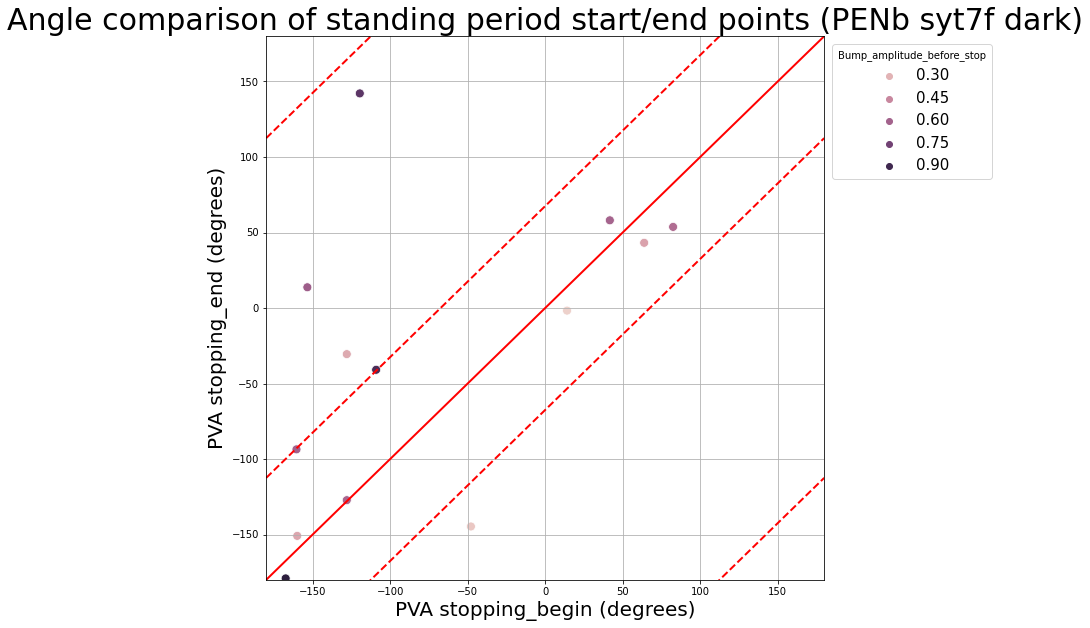

In [167]:
# UPDATE plt title and whatever else that's hard coded

plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = output_df, x='PVA_before_stop', y='PVA_at_restart', hue = 'bump_amplitude_before_stop',s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_before_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.plot(X_plot,Y_plot + 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot + 292.5, color= 'r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 292.5, color='r', linestyle ='--', linewidth =2)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Angle comparison of standing period start/end points (PENb syt7f dark)', fontsize =30)
plt.ylabel('PVA stopping_end (degrees)',fontsize= 20)
plt.xlabel('PVA stopping_begin (degrees)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.grid()
plt.show()

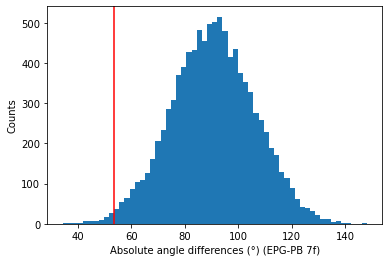

In [168]:
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto')
plt.axvline(x = actual_mean_absolute_angle_diff, color = 'r')
plt.xlabel('Absolute angle differences (°) (EPG-PB 7f)')
plt.ylabel('Counts')
plt.show()

In [169]:
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(persistence_data_pooled['PVA_before_stop'])

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(persistence_data_pooled['PVA_before_stop'],size = pair_num)
    random_stop_end_angle = np.random.choice(persistence_data_pooled['PVA_at_restart'],size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))    

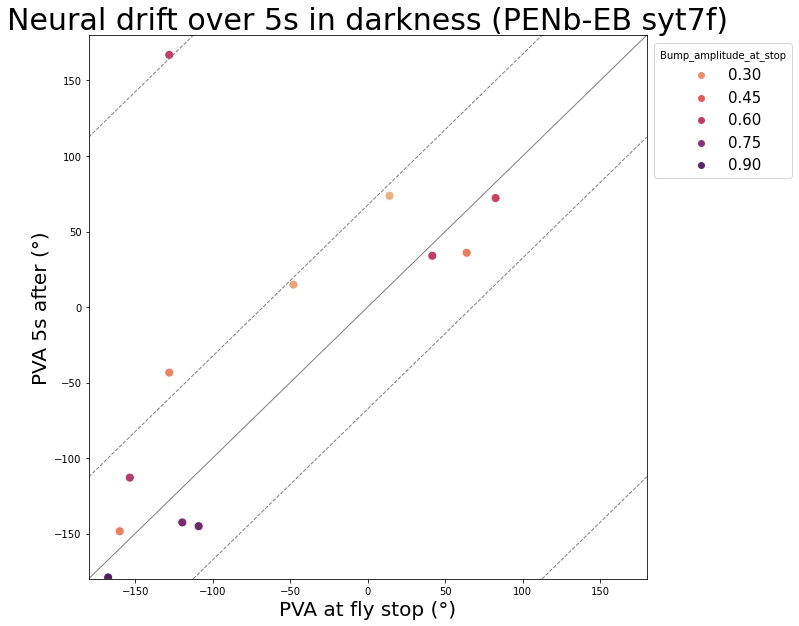

In [170]:
plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_5s_after_stop', palette = 'flare',hue = 'bump_amplitude_before_stop',s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_at_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='grey', linewidth =1)
plt.plot(X_plot,Y_plot + 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot + 292.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 292.5, color='grey', linestyle ='--', linewidth =1)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Neural drift over 5s in darkness (PENb-EB syt7f)', fontsize =30)
plt.ylabel('PVA 5s after (°)',fontsize= 20)
plt.xlabel('PVA at fly stop (°)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.show()

In [171]:
actual_angle_diff = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_at_restart'])
actual_mean_absolute_angle_diff = np.mean(np.abs(actual_angle_diff))
actual_mean_absolute_angle_diff 

53.67998102636837

In [172]:
actual_mean_absolute_angle_diff_5s

NameError: name 'actual_mean_absolute_angle_diff_5s' is not defined

In [173]:
stop_period_start_5s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_5s_after_stop'])==0)))
stop_period_end_5s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_5s_after_stop'])==0))) 
long_trial_index = np.argwhere(np.isnan(persistence_data_pooled['PVA_5s_after_stop'])==0)
for i in range(len(stop_period_start_5s )):
    stop_period_start_5s[i] = persistence_data_pooled['PVA_before_stop'][long_trial_index[i][0]]
    stop_period_end_5s[i] =  persistence_data_pooled['PVA_5s_after_stop'][long_trial_index[i][0]]
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(stop_period_start_5s)

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(stop_period_start_5s,size = pair_num)
    random_stop_end_angle = np.random.choice(stop_period_end_5s,size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))   

actual_mean_absolute_angle_diff_diff_5s =  calculate_angle_difference_between_two_time_point(stop_period_start_5s ,stop_period_end_5s)
actual_mean_absolute_angle_diff_5s = np.mean(np.abs(actual_mean_absolute_angle_diff_diff_5s))
actual_mean_absolute_angle_diff_5s     

plt.figure(figsize= (8,5))
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto', color = 'navy')
plt.axvline(x = actual_mean_absolute_angle_diff_5s, color = 'crimson',linewidth =3)
plt.xlabel('Absolute angle differences over 5s (°)',fontsize= 15)
plt.ylabel('Counts',fontsize= 15)
plt.show()   

ValueError: Length of values (1) does not match length of index (13)

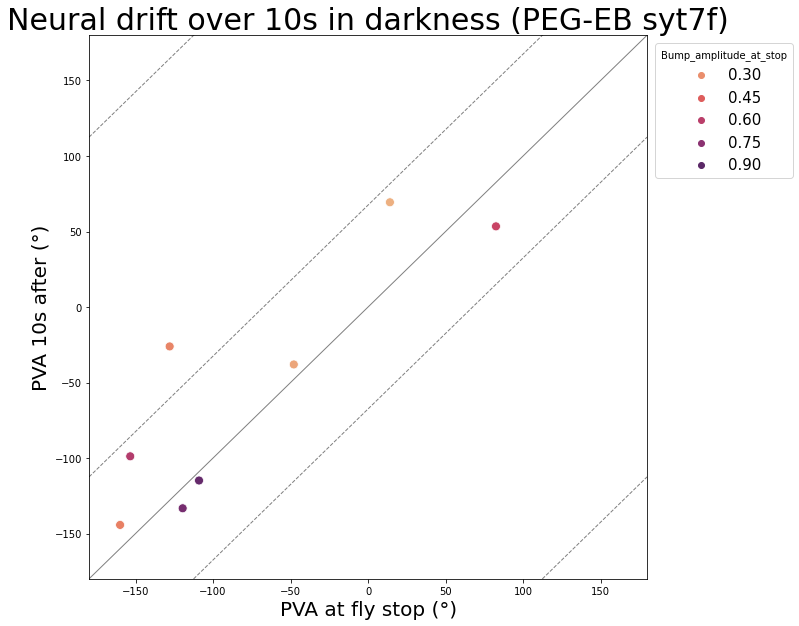

In [174]:
a = plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_10s_after_stop', palette = 'flare',hue = 'bump_amplitude_before_stop', s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_at_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='grey', linewidth =1)
plt.plot(X_plot,Y_plot + 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot + 292.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 292.5, color='grey', linestyle ='--', linewidth =1)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Neural drift over 10s in darkness (PEG-EB syt7f)', fontsize =30)
plt.ylabel('PVA 10s after (°)',fontsize= 20)
plt.xlabel('PVA at fly stop (°)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.show()
#a.savefig('E-PG_Bump_Angle_10s_after_cl', format ='svg')

In [175]:
stop_period_start_10s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_10s_after_stop'])==0)))
stop_period_end_10s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_10s_after_stop'])==0))) 
long_trial_index = np.argwhere(np.isnan(persistence_data_pooled['PVA_10s_after_stop'])==0)
for i in range(len(stop_period_start_10s )):
    stop_period_start_10s[i] = persistence_data_pooled['PVA_before_stop'][long_trial_index[i][0]]
    stop_period_end_10s[i] =  persistence_data_pooled['PVA_10s_after_stop'][long_trial_index[i][0]]
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(stop_period_start_10s)

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(stop_period_start_10s,size = pair_num)
    random_stop_end_angle = np.random.choice(stop_period_end_10s,size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))   

actual_mean_absolute_angle_diff_diff_10s =  calculate_angle_difference_between_two_time_point(stop_period_start_10s ,stop_period_end_10s)
actual_mean_absolute_angle_diff_10s = np.mean(np.abs(actual_mean_absolute_angle_diff_diff_10s))
actual_mean_absolute_angle_diff_10s     

plt.figure(figsize= (8,5))
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto',color = 'navy')
plt.axvline(x = actual_mean_absolute_angle_diff_10s, color = 'crimson',linewidth =3)
plt.xlabel('Absolute angle differences over 10s (°)',fontsize= 15)
plt.ylabel('Counts',fontsize= 15)
plt.show()

ValueError: Length of values (1) does not match length of index (13)

In [176]:
np.quantile(bootstrap_mean_angle_differences_10000,0.000000000001)

38.91081593302902

In [177]:
len(long_trial_index)

NameError: name 'long_trial_index' is not defined

In [178]:
actual_mean_absolute_angle_diff_10s    

NameError: name 'actual_mean_absolute_angle_diff_10s' is not defined

In [179]:
#from scipy.stats import ranksums
#ranksums(np.abs(actual_mean_absolute_angle_diff_dark_diff), np.abs(actual_mean_absolute_angle_diff_cl_diff))

In [180]:
stats.mannwhitneyu(np.abs(actual_mean_absolute_angle_diff_dark_diff), np.abs(actual_mean_absolute_angle_diff_cl_diff), alternative = 'two-sided')

NameError: name 'actual_mean_absolute_angle_diff_dark_diff' is not defined

In [181]:
np.savetxt('angle_difference_cl_10s.csv', np.abs(actual_mean_absolute_angle_diff_cl_diff))

NameError: name 'actual_mean_absolute_angle_diff_cl_diff' is not defined

In [182]:
persistence_data_pooled['angle difference start/middle'] = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_in_middle'])

In [183]:
persistence_data_pooled['angle difference start/end'] = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_at_restart'])

In [184]:
persistence_data_pooled

FlyTrial Genotype TrialType  Period_duration  PVA_before_stop  \
0   TQfly005-006   unsure        cl          7.81060      -128.021976   
1   TQfly005-006   unsure        cl         20.41914      -119.617959   
2   TQfly005-006   unsure        cl         11.26958       -47.919241   
3   TQfly005-006   unsure        cl         12.60854      -128.007671   
4   TQfly005-006   unsure        cl          5.02110      -167.444203   
5   TQfly005-006   unsure        cl          3.01266      -160.461836   
6   TQfly005-006   unsure        cl         14.72856      -109.065552   
7   TQfly005-006   unsure        cl         17.07174      -159.986184   
8   TQfly005-006   unsure        cl         49.31836      -153.451825   
9   TQfly005-006   unsure        cl         10.71168        14.093923   
10  TQfly005-006   unsure        cl         11.93906        82.513014   
11  TQfly005-006   unsure        cl          5.35584        63.847548   
12  TQfly005-006   unsure        cl          6.80638        41.699168   

    PVA_at_restart  PVA_100ms_before_restart  PVA_500ms_before_restart  \
0      -127.265801                127.441139               -171.935407   
1       142.123933               -163.931565                -51.891427   
2      -144.687453                -65.426535                -33.176779   
3       -30.550294                -74.257957                -79.515135   
4      -179.079718                170.909464               -179.263158   
5       -93.609284               -127.218838               -148.311211   
6       -40.905757               -154.108183               -148.728859   
7      -150.910618                -82.275658                -36.543651   
8        13.734617                 83.808172                 22.605839   
9        -1.729706                -81.807231                 -4.047145   
10       53.707998                 44.681617                 31.090628   
11       43.170427                 44.716363                 26.338964   
12       58.083414                 55.058043                 49.593839   

    PVA_in_middle  PVA_2s_before_restart  ...  \
0      179.943183              90.551037  ...   
1     -129.128776            -112.627013  ...   
2      -81.728236            -108.485177  ...   
3      -42.003627             -27.642148  ...   
4     -167.668122            -172.106724  ...   
5     -155.911979            -166.782814  ...   
6     -159.494388             -92.797531  ...   
7      -85.885774             -98.933580  ...   
8      154.969961              39.781948  ...   
9       31.677573              50.266118  ...   
10      65.108192              53.414899  ...   
11      34.679460              49.056903  ...   
12      46.152116              31.890216  ...   

    bump_amplitude_100ms_before_restart  bump_amplitude_500ms_before_restart  \
0                              0.165611                             0.308986   
1                              0.168018                             0.245180   
2                              0.204614                             0.280815   
3                              0.243646                             0.234543   
4                              0.616762                             0.604997   
5                              0.335331                             0.471189   
6                              0.084517                             0.172077   
7                              0.166998                             0.170403   
8                              0.193495                             0.311410   
9                              0.095935                             0.238483   
10                             0.317636                             0.234066   
11                             0.642251                             0.584826   
12                             0.473140                             0.400702   

    bump_amplitude_in_middle  bump_amplitude_2s_before_restart  \
0                   0.488207                          0.219757   
1       

In [185]:
persistence_data_pooled.to_csv('/home/tianhaoqiu/Documents/persistence_data_pooled_EPG_7f_PB_cl.csv',encoding = 'utf-8', index=False)

OSError: Cannot save file into a non-existent directory: '\home\tianhaoqiu\Documents'